In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.preprocessing  import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statsmodels.tools.eval_measures import mse, rmse
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
csv_files = [file for file in os.listdir() if file.endswith('csv') and file not in 
             ['df_merged_hot.csv', 'tweets_df.csv', 'check3.csv', 'df_merged.csv']]

In [4]:
df_list = []

for file in csv_files:
    df_list.append(pd.read_csv(file))

In [3]:
csv_files

['crop_rotation.csv',
 'gross_nutrient_balance.csv',
 'irrigation.csv',
 'legal_form.csv',
 'pesticides.csv',
 'precipitation.csv',
 'soil_erosion.csv',
 'temperature.csv',
 'tenure_status.csv',
 'training.csv',
 'yields.csv']

In [54]:
eu27_codes = ['AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'EL', 'HU', 'IE', 'IT', 'LV', 'LT',
              'LU', 'MT', 'NL', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE']

In [6]:
# Let's examine crop_rotation
df_list[0].head()

Unnamed: 0 freq crop_rot tillage farmtype agrarea unit geo\TIME_PERIOD  \
0        2503    A      NAP     ARA  FT16_SO   TOTAL   HA              AT   
1        2504    A      NAP     ARA  FT16_SO   TOTAL   HA            AT11   
2        2505    A      NAP     ARA  FT16_SO   TOTAL   HA            AT12   
3        2506    A      NAP     ARA  FT16_SO   TOTAL   HA            AT13   
4        2507    A      NAP     ARA  FT16_SO   TOTAL   HA            AT21   

   2010  2016  
0   NaN   0.0  
1   NaN   0.0  
2   NaN   0.0  
3   NaN   0.0  
4   NaN   0.0

In [7]:
crop_rotation_df = df_list[0]

In [8]:
def rename_filter_drop(df, old_col_name, new_col_name, filter_var, filter_val, cols_to_drop):
    """
    Renames a column in a DataFrame, filters for specific values of another column and drops a list of columns.
    
    Paramters:
    df (pandas DataFrame): The DataFrame to operate on
    old_col_name (str): The column name which is to be changed
    new_col_name (str): The new column name to be used
    filter_var (str): The variable which is to be filtered
    filter_val (list): The values to be filtered for
    cols_to_drop (list): The columns to be dropped
    
    """
    
    df = df.rename(columns = {old_col_name: new_col_name})
    df = df[df[filter_var].isin(filter_val)]
    df = df.drop(columns = cols_to_drop)
    return df

In [9]:
crop_rotation_df = rename_filter_drop(crop_rotation_df, 'geo\TIME_PERIOD', 'geo', 'geo', eu27_codes, 
                                      ['Unnamed: 0', 'freq', 'agrarea'])

In [10]:
crop_rotation_df.head()

crop_rot tillage farmtype unit geo  2010  2016
0       NAP     ARA  FT16_SO   HA  AT   NaN   0.0
10      NAP     ARA  FT16_SO   HA  BE   NaN   0.0
22      NAP     ARA  FT16_SO   HA  BG   NaN   0.0
29      NAP     ARA  FT16_SO   HA  CZ   NaN   0.0
36      NAP     ARA  FT16_SO   HA  DE   NaN   0.0

In [11]:
crop_rotation_df_long = crop_rotation_df.melt(id_vars = ['crop_rot', 'tillage', 'farmtype', 'unit', 'geo'], 
                                              value_vars = ['2010', '2016'], var_name = 'Year')

In [12]:
crop_rotation_df_long.head()

crop_rot tillage farmtype unit geo  Year  value
0      NAP     ARA  FT16_SO   HA  AT  2010    NaN
1      NAP     ARA  FT16_SO   HA  BE  2010    NaN
2      NAP     ARA  FT16_SO   HA  BG  2010    NaN
3      NAP     ARA  FT16_SO   HA  CZ  2010    NaN
4      NAP     ARA  FT16_SO   HA  DE  2010    NaN

In [13]:
# Seen as this doesn't seem to be working, I could filter for the group and then use the tried and tested way
# Actually it seems to be working if you replace the x.size with len(x)

def grouped_null_counts(df, group):
    df = df.groupby(group).apply(lambda x: (x.isnull().sum() / len(x)) * 100)
    return df

In [14]:
# There's only 2010 data for the TOTAL crop_rot but the below doesn't seem to suggest that
# This should be working now although I haven't re-run things as of this comment

null_counts_crop_rot = grouped_null_counts(crop_rotation_df_long, 'crop_rot')
null_counts_geo = grouped_null_counts(crop_rotation_df_long, 'geo')
null_counts_year = grouped_null_counts(crop_rotation_df_long, 'Year')
print(null_counts_crop_rot)
print(null_counts_geo)
print(null_counts_year)

          crop_rot  tillage  farmtype  unit  geo  Year      value
crop_rot                                                         
NAP            0.0      0.0       0.0   0.0  0.0   0.0  52.500000
PC0            0.0      0.0       0.0   0.0  0.0   0.0  52.500000
PC1-24         0.0      0.0       0.0   0.0  0.0   0.0  52.380952
PC25-49        0.0      0.0       0.0   0.0  0.0   0.0  54.545455
PC50-74        0.0      0.0       0.0   0.0  0.0   0.0  52.272727
PC_GE75        0.0      0.0       0.0   0.0  0.0   0.0  50.000000
TOTAL          0.0      0.0       0.0   0.0  0.0   0.0  23.913043
     crop_rot  tillage  farmtype  unit  geo  Year      value
geo                                                         
AT        0.0      0.0       0.0   0.0  0.0   0.0  42.857143
BE        0.0      0.0       0.0   0.0  0.0   0.0  50.000000
BG        0.0      0.0       0.0   0.0  0.0   0.0  42.857143
CY        0.0      0.0       0.0   0.0  0.0   0.0  50.000000
CZ        0.0      0.0       0.0   0.0  

In [30]:
crop_rotation_df_long[crop_rotation_df_long.Year == '2010'].value.isnull().sum() / len(crop_rotation_df_long[crop_rotation_df_long.Year == '2010'].value)

0.92

In [31]:
null_values = crop_rotation_df_long[crop_rotation_df_long.value.isnull()]
null_values

crop_rot tillage farmtype unit geo  Year  value
0        NAP     ARA  FT16_SO   HA  AT  2010    NaN
1        NAP     ARA  FT16_SO   HA  BE  2010    NaN
2        NAP     ARA  FT16_SO   HA  BG  2010    NaN
3        NAP     ARA  FT16_SO   HA  CZ  2010    NaN
4        NAP     ARA  FT16_SO   HA  DE  2010    NaN
..       ...     ...      ...  ...  ..   ...    ...
189      PC0     ARA  FT16_SO   HA  SK  2016    NaN
204   PC1-24     ARA  FT16_SO   HA  LU  2016    NaN
225  PC25-49     ARA  FT16_SO   HA  LU  2016    NaN
232  PC25-49     ARA  FT16_SO   HA  SK  2016    NaN
254  PC50-74     ARA  FT16_SO   HA  SK  2016    NaN

[144 rows x 7 columns]

In [32]:
crop_rotation_total = crop_rotation_df_long[crop_rotation_df_long.crop_rot == 'TOTAL']

In [33]:
crop_rotation_total.head()

crop_rot tillage farmtype unit geo  Year     value
127    TOTAL     ARA  FT16_SO   HA  AT  2010  265360.0
128    TOTAL     ARA  FT16_SO   HA  BE  2010       NaN
129    TOTAL     ARA  FT16_SO   HA  BG  2010  204310.0
130    TOTAL     ARA  FT16_SO   HA  CY  2010       NaN
131    TOTAL     ARA  FT16_SO   HA  CZ  2010  278910.0

In [34]:
crop_rot_join = pd.merge(crop_rotation_df_long, crop_rotation_total, on = ['tillage', 'farmtype', 'unit', 'geo', 'Year'], 
                         how = 'left', suffixes = ('', '_total'))

In [35]:
crop_rot_join.head()

crop_rot tillage farmtype unit geo  Year  value crop_rot_total  value_total
0      NAP     ARA  FT16_SO   HA  AT  2010    NaN          TOTAL     265360.0
1      NAP     ARA  FT16_SO   HA  BE  2010    NaN          TOTAL          NaN
2      NAP     ARA  FT16_SO   HA  BG  2010    NaN          TOTAL     204310.0
3      NAP     ARA  FT16_SO   HA  CZ  2010    NaN          TOTAL     278910.0
4      NAP     ARA  FT16_SO   HA  DE  2010    NaN          TOTAL          NaN

In [36]:
crop_rot_join['share'] = crop_rot_join.value/crop_rot_join.value_total * 100

In [37]:
crop_rot_join.head()

crop_rot tillage farmtype unit geo  Year  value crop_rot_total  value_total  \
0      NAP     ARA  FT16_SO   HA  AT  2010    NaN          TOTAL     265360.0   
1      NAP     ARA  FT16_SO   HA  BE  2010    NaN          TOTAL          NaN   
2      NAP     ARA  FT16_SO   HA  BG  2010    NaN          TOTAL     204310.0   
3      NAP     ARA  FT16_SO   HA  CZ  2010    NaN          TOTAL     278910.0   
4      NAP     ARA  FT16_SO   HA  DE  2010    NaN          TOTAL          NaN   

   share  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN

In [38]:
crop_rot_join_graph = crop_rot_join[crop_rot_join.crop_rot != 'TOTAL']

In [39]:
crop_rot_join_graph.crop_rot.unique()

array(['NAP', 'PC0', 'PC1-24', 'PC25-49', 'PC50-74', 'PC_GE75'],
      dtype=object)

C:\Users\justi\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


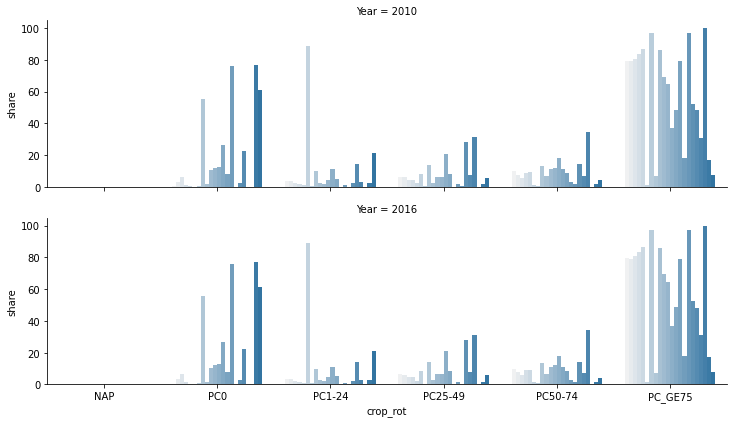

In [40]:

crop_rot_join_graph = crop_rot_join[crop_rot_join.crop_rot != 'TOTAL']

g = sns.FacetGrid(crop_rot_join_graph, row = 'Year')

g.map(sns.barplot, x = crop_rot_join_graph.crop_rot, y = crop_rot_join_graph.share, hue = crop_rot_join_graph.geo)

g.fig.set_size_inches(14, 6)

plt.show()

In [41]:
#crop_rot_join_graph_2010.to_csv('check.csv')
#crop_rot_join_graph.to_csv('check2.csv')
crop_rotation_df_long.to_csv('check3.csv')

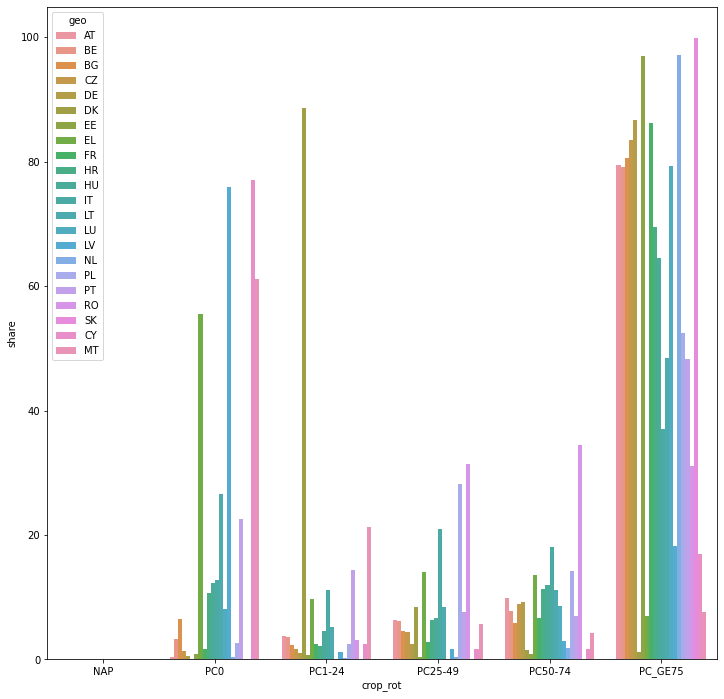

In [42]:
# The data appears to be almost identical between the two years, let's take a closer look by only considering 2010
# Correction there isn't really any data for 2010, not sure why we get the above graph

crop_rot_join_graph_2016 = crop_rot_join_graph[crop_rot_join_graph.Year == '2016']

fig, ax = plt.subplots(figsize = (12, 12))

sns.barplot(data = crop_rot_join_graph_2016, x = crop_rot_join_graph_2016.crop_rot, y = crop_rot_join_graph_2016.share,
           hue = crop_rot_join_graph_2016.geo, ax = ax)



plt.show()

In [43]:
def categorical_converter(x):
    if x < 20:
        return 'very low'
    elif 20 <= x < 40:
        return 'low'
    elif 40 <= x < 60:
        return 'medium'
    elif 60 <= x < 80:
        return 'high'
    else:
        return 'very high'

In [44]:
# From the graph above, there are only 0 values for NAP so let's remove them
# I also want to pivot by crop rotation
# from visual inspection of the data, values of NaN are actually 0 values
# I know this because I've calcualated shares and the values add up 100% if I replace NaN with 0
# As I only have values for 1 year, I want to treat this data as a categorical variable rather than numerical
# I adjust for that below



crop_rot_clean = crop_rot_join_graph_2016[crop_rot_join_graph_2016.crop_rot != 'NAP'] \
                    .pivot(index = ['tillage', 'farmtype', 'unit', 'geo'], columns = 'crop_rot', values = 'share') \
                    .reset_index() \
                    .fillna(0) \
                    .drop(columns = ['tillage', 'farmtype', 'unit'])

for col in crop_rot_clean.select_dtypes(include = ['int', 'float']).columns:
    crop_rot_clean[col] = crop_rot_clean[col].apply(categorical_converter)



In [45]:
crop_rot_clean.head()

crop_rot geo       PC0    PC1-24   PC25-49   PC50-74    PC_GE75
0         AT  very low  very low  very low  very low       high
1         BE  very low  very low  very low  very low       high
2         BG  very low  very low  very low  very low  very high
3         CY      high  very low  very low  very low   very low
4         CZ  very low  very low  very low  very low  very high

In [46]:
# Moving onto gross nutrient balance

df_list[1].head()

Unnamed: 0 freq nutrient indic_ag geo\TIME_PERIOD      1985      1986  \
0           0    A        N      BAL              AT  178458.0  166581.0   
1           1    A        N      BAL              BE       NaN       NaN   
2           2    A        N      BAL              BG       NaN       NaN   
3           3    A        N      BAL              CH       NaN       NaN   
4           4    A        N      BAL              CY       NaN       NaN   

       1987      1988      1989  ...      2010      2011      2012      2013  \
0  154038.0  154390.0  146568.0  ...  101664.7  101889.6   95485.9  125087.3   
1       NaN       NaN       NaN  ...  192787.6  191515.9  190844.7  184567.8   
2       NaN  742514.0  608229.0  ...   71741.0   60296.9  123980.7   78959.4   
3       NaN       NaN       NaN  ...  104784.8   89503.5   91809.3  104265.8   
4       NaN       NaN       NaN  ...   21975.8   23027.4   21384.0   19127.3   

       2014      2015      2016      2017      2018      2019  
0   80686.1  121257.8   77552.8  118011.2  121734.8   90473.8  
1  175550.1  175550.0       NaN       NaN       NaN       NaN  
2  137486.8  137487.0  357189.5  331185.0  310857.8  144975.2  
3   98547.5  104978.9  105642.2   92871.2  101459.8   89579.8  
4   20792.7   20793.0       NaN       NaN       NaN       NaN  

[5 rows x 40 columns]

In [19]:
nut_bal_df = df_list[1]

In [20]:
nut_bal_df.columns

Index(['Unnamed: 0', 'freq', 'nutrient', 'indic_ag', 'geo\TIME_PERIOD', '1985',
       '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2019'],
      dtype='object')

In [21]:
nut_bal_df = rename_filter_drop(nut_bal_df, 'geo\TIME_PERIOD', 'geo', 'geo', eu27_codes, ['Unnamed: 0', 'freq'])

In [22]:
nut_bal_df_long = nut_bal_df.melt(id_vars = ['nutrient', 'indic_ag', 'geo'], var_name = 'Year')

In [23]:
nut_bal_df_long.head()

nutrient indic_ag geo  Year     value
0        N      BAL  AT  1985  178458.0
1        N      BAL  BE  1985       NaN
2        N      BAL  BG  1985       NaN
3        N      BAL  CY  1985       NaN
4        N      BAL  CZ  1985  454385.0

In [24]:
def null_share(df):
    df = df.isnull().sum() / len(df) * 100
    return df
    

In [25]:
null_share(nut_bal_df_long)

nutrient     0.000000
indic_ag     0.000000
geo          0.000000
Year         0.000000
value       24.032578
dtype: float64

In [26]:
grouped_null_counts(nut_bal_df_long, 'Year')

nutrient  indic_ag  geo  Year      value
Year                                          
1985       0.0       0.0  0.0   0.0  83.410375
1986       0.0       0.0  0.0   0.0  83.410375
1987       0.0       0.0  0.0   0.0  83.410375
1988       0.0       0.0  0.0   0.0  79.917822
1989       0.0       0.0  0.0   0.0  79.917822
1990       0.0       0.0  0.0   0.0  26.810478
1991       0.0       0.0  0.0   0.0  24.756035
1992       0.0       0.0  0.0   0.0  22.958398
1993       0.0       0.0  0.0   0.0  22.958398
1994       0.0       0.0  0.0   0.0  22.958398
1995       0.0       0.0  0.0   0.0  19.106317
1996       0.0       0.0  0.0   0.0  19.106317
1997       0.0       0.0  0.0   0.0  19.106317
1998       0.0       0.0  0.0   0.0  19.106317
1999       0.0       0.0  0.0   0.0  19.106317
2000       0.0       0.0  0.0   0.0   3.903441
2001       0.0       0.0  0.0   0.0   3.903441
2002       0.0       0.0  0.0   0.0   3.903441
2003       0.0       0.0  0.0   0.0   3.903441
2004       0.0       0.0  0.0   0.0   0.462250
2005       0.0       0.0  0.0   0.0   0.462250
2006       0.0       0.0  0.0   0.0   0.462250
2007       0.0       0.0  0.0   0.0   0.462250
2008       0.0       0.0  0.0   0.0   0.462250
2009       0.0       0.0  0.0   0.0   0.462250
2010       0.0       0.0  0.0   0.0   0.462250
2011       0.0       0.0  0.0   0.0   0.462250
2012       0.0       0.0  0.0   0.0   0.462250
2013       0.0       0.0  0.0   0.0   3.903441
2014       0.0       0.0  0.0   0.0   3.903441
2015       0.0       0.0  0.0   0.0  35.952748
2016       0.0       0.0  0.0   0.0  31.587057
2017       0.0       0.0  0.0   0.0  32.460195
2018       0.0       0.0  0.0   0.0  43.810991
2019       0.0       0.0  0.0   0.0  43.708269

In [55]:
# A lot of values from the 80s are null but these are no use to me anyway since the fertility data doesn't go back that far
# I'll remove these
# There are very few other missing values so I'll simply fill these with 'ffill' seen as there are some missing values in 2019
# So 'bfill' might not produce a value for the 2019 values

In [27]:
nut_bal_df_long = nut_bal_df_long[nut_bal_df_long.Year >= '1990'].fillna(method = 'ffill')

In [30]:
nut_bal_df_long.indic_ag.unique()

array(['BAL', 'BAL_NET', 'BAL_NET_UAA', 'BAL_UAA', 'INP_NT', 'INP_UAA',
       'I_FRT', 'I_FRT_MIN', 'I_FRT_ORG', 'I_MNR', 'I_MNR_IMP',
       'I_MNR_PCT', 'I_MNR_POTH', 'I_MNR_PPG', 'I_MNR_PPL', 'I_MNR_PRD',
       'I_MNR_PSP', 'I_MNR_WDR', 'I_OTH', 'I_OTH_BIO', 'I_OTH_DEP',
       'I_OTH_SEED', 'OUT_NT', 'OUT_UAA', 'O_BRN', 'O_CRP', 'O_CRP_CER',
       'O_CRP_FRU', 'O_CRP_IND', 'O_CRP_ORN', 'O_CRP_OTH', 'O_CRP_PUL',
       'O_CRP_ROO', 'O_CRP_VEG', 'O_FOD', 'O_FOD_PGA', 'O_FOD_PGR',
       'O_RES', 'TOT_N_EMIS', 'UAA'], dtype=object)

In [58]:
nut_bal_df_long_N = nut_bal_df_long[(nut_bal_df_long.nutrient == 'N') & 
                                    (nut_bal_df_long.indic_ag.isin(['BAL_UAA', 'INP_UAA', 'OUT_UAA'])) &
                                    (nut_bal_df_long.geo.isin(['BE', 'DK', 'FR, DE', 'IE', 'NL']))]



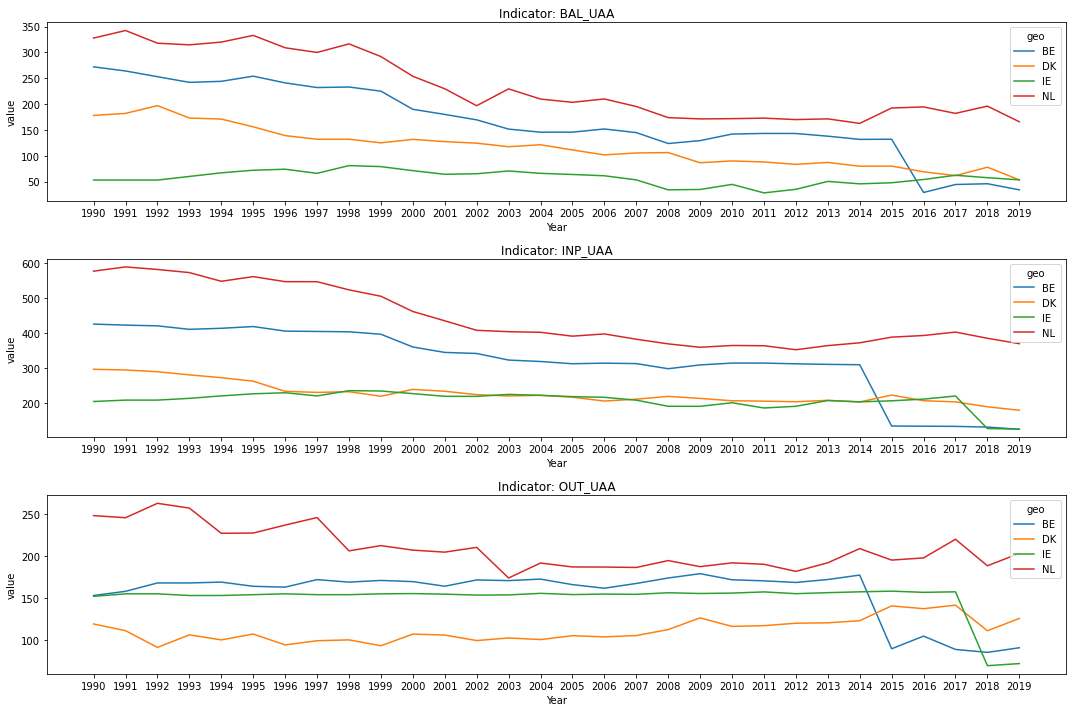

In [59]:
f, ax = plt.subplots(nut_bal_df_long_N.indic_ag.unique().size, 1, figsize = (15, 10))

for i, indic_ag in enumerate(nut_bal_df_long_N.indic_ag.unique()):
    
    nut_bal_long_graph = nut_bal_df_long_N[nut_bal_df_long_N['indic_ag'] == indic_ag]
    
    sns.lineplot(x = 'Year', y = 'value', hue = 'geo', data = nut_bal_long_graph, ax = ax[i])
    
    #ax[i].set_yscale('log')
    ax[i].set_title(f'Indicator: {indic_ag}')
    
plt.tight_layout()

In [60]:
null_share(nut_bal_df_long)

nutrient    0.0
indic_ag    0.0
geo         0.0
Year        0.0
value       0.0
dtype: float64

In [61]:
nut_bal_group = nut_bal_df_long.groupby(['nutrient', 'indic_ag', 'geo']).mean().reset_index()

In [62]:
nut_bal_group.head()

nutrient indic_ag geo          value
0        N      BAL  AT  128322.850000
1        N      BAL  BE  234462.466667
2        N      BAL  BG  194518.560000
3        N      BAL  CY   60074.126667
4        N      BAL  CZ  273372.450000

In [63]:
nut_bal_group_graph = nut_bal_group[nut_bal_group.indic_ag.isin(['BAL_UAA', 'INP_UAA', 'OUT_UAA'])]

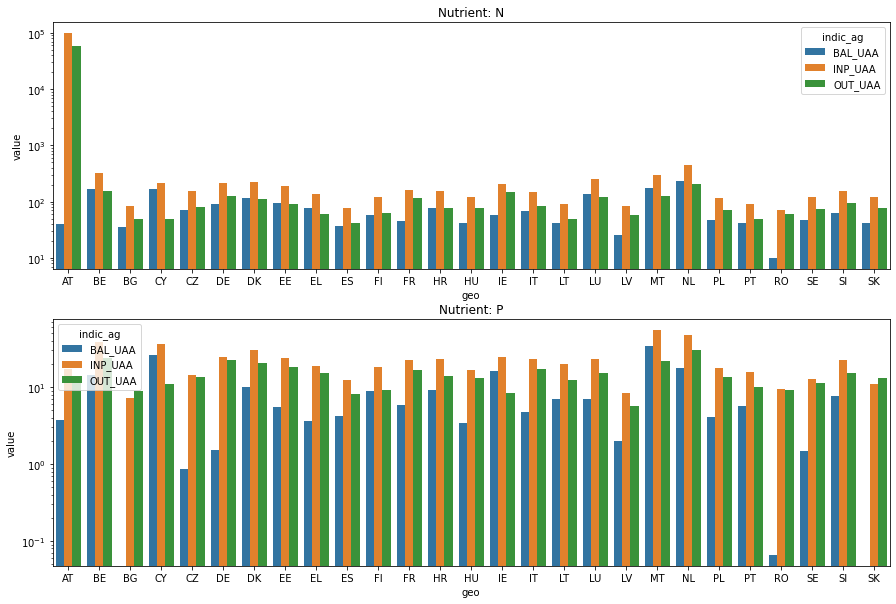

In [64]:
f, ax = plt.subplots(2, 1, figsize = (15, 10))

for i, nutrient in enumerate(nut_bal_group_graph.nutrient.unique()):
    
    nut_bal_graph = nut_bal_group_graph[nut_bal_group_graph['nutrient'] == nutrient]
    
    sns.barplot(x = 'geo', y = 'value', hue = 'indic_ag', data = nut_bal_graph, ax = ax[i])
    
    ax[i].set_yscale('log')
    ax[i].set_title(f'Nutrient: {nutrient}')


In [65]:
nut_bal_group_graph.head()

nutrient indic_ag geo       value
81        N  BAL_UAA  AT   40.273333
82        N  BAL_UAA  BE  165.840000
83        N  BAL_UAA  BG   35.066667
84        N  BAL_UAA  CY  171.020000
85        N  BAL_UAA  CZ   72.013333

In [66]:
nut_bal_N = nut_bal_df_long[(nut_bal_df_long.nutrient == 'N') & 
                            (nut_bal_df_long.indic_ag.isin(['BAL_UAA', 'INP_UAA', 'OUT_UAA']))]

nut_bal_N_wide = nut_bal_N.pivot(index = ['nutrient', 'geo', 'Year'], columns = 'indic_ag', values = 'value').reset_index()

In [67]:
nut_bal_P = nut_bal_df_long[(nut_bal_df_long.nutrient == 'P') & 
                            (nut_bal_df_long.indic_ag.isin(['BAL_UAA', 'INP_UAA', 'OUT_UAA']))]

nut_bal_P_wide = nut_bal_P.pivot(index = ['nutrient', 'geo', 'Year'], columns = 'indic_ag', values = 'value').reset_index()

In [68]:
nut_bal_clean = pd.merge(nut_bal_N_wide, nut_bal_P_wide, on = ['geo', 'Year'], how = 'inner', suffixes = ('_N', '_P')) \
                  .drop(columns = ['nutrient_N', 'nutrient_P'])

In [69]:
nut_bal_clean.head()

indic_ag geo  Year  BAL_UAA_N  INP_UAA_N  OUT_UAA_N  BAL_UAA_P  INP_UAA_P  \
0         AT  1990       47.0   468924.0   193401.0        8.0       22.0   
1         AT  1991       46.0   381259.0   197992.0        8.0       22.0   
2         AT  1992       57.0   311506.0   177135.0        7.0       20.0   
3         AT  1993       50.0   265903.0   163241.0        7.0       20.0   
4         AT  1994       44.0   259926.0   183119.0        6.0       19.0   

indic_ag  OUT_UAA_P  
0              14.0  
1              14.0  
2              14.0  
3              13.0  
4              14.0

In [70]:
# Moving onto irrigation

In [71]:
irrigation_df = df_list[2]

In [72]:
irrigation_df.head()

Unnamed: 0 freq irr_area so_eur agrarea unit geo\TIME_PERIOD      2013  \
0       63720    A    UAAIB  TOTAL   TOTAL   HA              AT  119840.0   
1       63721    A    UAAIB  TOTAL   TOTAL   HA            AT11   26640.0   
2       63722    A    UAAIB  TOTAL   TOTAL   HA            AT12   80760.0   
3       63723    A    UAAIB  TOTAL   TOTAL   HA            AT13    2210.0   
4       63724    A    UAAIB  TOTAL   TOTAL   HA            AT21    1250.0   

      2016  
0  99750.0  
1  22610.0  
2  63570.0  
3   2180.0  
4   1350.0

In [73]:
irrigation_df = rename_filter_drop(irrigation_df, 'geo\TIME_PERIOD', 'geo', 'geo', eu27_codes, ['Unnamed: 0', 'freq'])

In [74]:
irrigation_df.head()

irr_area so_eur agrarea unit geo      2013      2016
0     UAAIB  TOTAL   TOTAL   HA  AT  119840.0   99750.0
10    UAAIB  TOTAL   TOTAL   HA  BE   19180.0   24110.0
22    UAAIB  TOTAL   TOTAL   HA  BG  115520.0  136350.0
29    UAAIB  TOTAL   TOTAL   HA  CY   38060.0   38140.0
31    UAAIB  TOTAL   TOTAL   HA  CZ   34070.0   45850.0

In [75]:
irrigation_df_long = irrigation_df.melt(id_vars = ['irr_area', 'geo'], var_name = 'Year', value_vars = ['2013', '2016'])

In [76]:
irrigation_df_long.head()

irr_area geo  Year     value
0    UAAIB  AT  2013  119840.0
1    UAAIB  BE  2013   19180.0
2    UAAIB  BG  2013  115520.0
3    UAAIB  CY  2013   38060.0
4    UAAIB  CZ  2013   34070.0

In [77]:
null_share(irrigation_df_long)

irr_area    0.000000
geo         0.000000
Year        0.000000
value       1.851852
dtype: float64

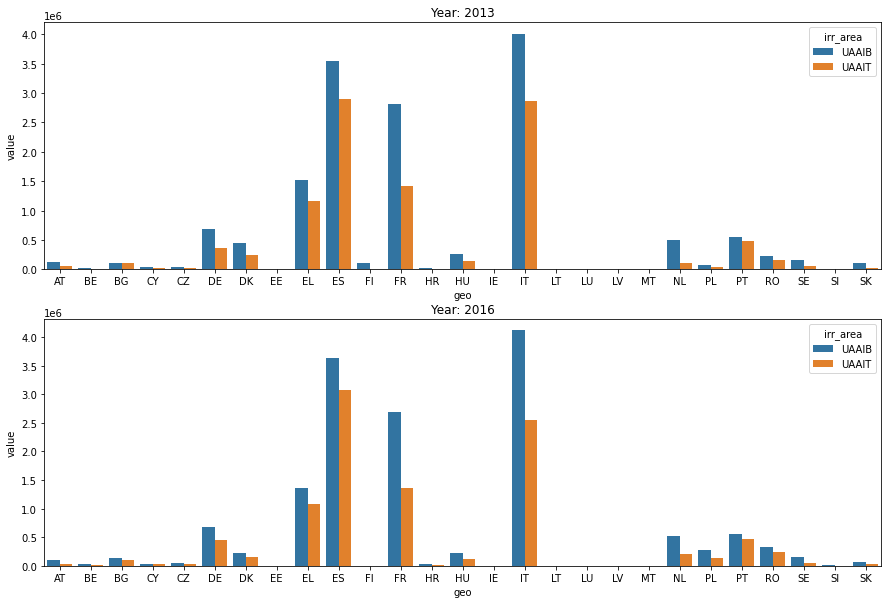

In [78]:
f, ax = plt.subplots(2, 1, figsize = (15, 10))

for i, year in enumerate(irrigation_df_long.Year.unique()):
    
    irrigation_graph = irrigation_df_long[irrigation_df_long['Year'] == year]
    
    sns.barplot(x = 'geo', y = 'value', hue = 'irr_area', data = irrigation_graph, ax = ax[i])
    
    #ax[i].set_yscale('log')
    ax[i].set_title(f'Year: {year}')

In [79]:
irrigation_df_long.head()

irr_area geo  Year     value
0    UAAIB  AT  2013  119840.0
1    UAAIB  BE  2013   19180.0
2    UAAIB  BG  2013  115520.0
3    UAAIB  CY  2013   38060.0
4    UAAIB  CZ  2013   34070.0

In [80]:
irrigation_potential = irrigation_df_long[irrigation_df_long.irr_area == 'UAAIB']

In [81]:
irrigation_join = pd.merge(irrigation_df_long, irrigation_potential, on = ['geo', 'Year'], how = 'left', 
                            suffixes = ('_act', '_pot'))

In [82]:
irrigation_join['share'] = irrigation_join.value_act.div(irrigation_join.value_pot).mul(100)


In [83]:
irrigation_join = irrigation_join[irrigation_join['irr_area_act'] == 'UAAIT']

In [84]:
irrigation_join.head()

irr_area_act geo  Year  value_act irr_area_pot  value_pot      share
27        UAAIT  AT  2013    51680.0        UAAIB   119840.0  43.124166
28        UAAIT  BE  2013     5740.0        UAAIB    19180.0  29.927007
29        UAAIT  BG  2013    98670.0        UAAIB   115520.0  85.413781
30        UAAIT  CY  2013    24670.0        UAAIB    38060.0  64.818707
31        UAAIT  CZ  2013    17840.0        UAAIB    34070.0  52.362783

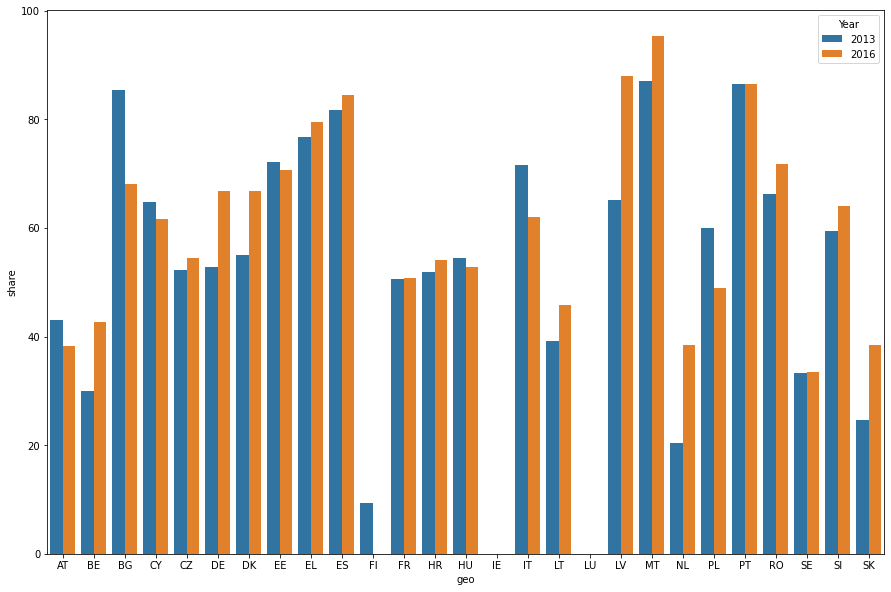

In [85]:
f, ax = plt.subplots(figsize = (15, 10))

sns.barplot(data = irrigation_join, x = 'geo', y = 'share', hue = 'Year', ax = ax)

plt.show()

In [86]:
# As the values are quite similar (statistical test?) and because I've only 2 datapoints, I'm going to average the two
# and convert to categorical data

In [87]:
irrigation_join.head()

irr_area_act geo  Year  value_act irr_area_pot  value_pot      share
27        UAAIT  AT  2013    51680.0        UAAIB   119840.0  43.124166
28        UAAIT  BE  2013     5740.0        UAAIB    19180.0  29.927007
29        UAAIT  BG  2013    98670.0        UAAIB   115520.0  85.413781
30        UAAIT  CY  2013    24670.0        UAAIB    38060.0  64.818707
31        UAAIT  CZ  2013    17840.0        UAAIB    34070.0  52.362783

In [88]:
irrigation_join_mean = irrigation_join.groupby('geo').mean().reset_index().drop(columns = ['value_act', 'value_pot'])

In [89]:
irrigation_join_mean.head()

geo      share
0  AT  40.704940
1  BE  36.282458
2  BG  76.773631
3  CY  63.203795
4  CZ  53.433300

In [90]:
irrigation_join_mean['irrigation'] = irrigation_join_mean.share.apply(categorical_converter)

In [91]:
irrigation_join_mean.head()

geo      share irrigation
0  AT  40.704940     medium
1  BE  36.282458        low
2  BG  76.773631       high
3  CY  63.203795       high
4  CZ  53.433300     medium

In [92]:
irrigation_clean = irrigation_join_mean.drop(columns = 'share')

In [93]:
irrigation_clean.head()

geo irrigation
0  AT     medium
1  BE        low
2  BG       high
3  CY       high
4  CZ     medium

In [94]:
# Moving onto legal form

In [95]:
legal_form_df = df_list[3]

In [96]:
legal_form_df.head()

Unnamed: 0 freq cons_prd crops farmtype leg_form  agrarea so_eur unit  \
0     8350045    A    TOTAL   ARA  FT16_SO  HLD_GRP  HA10-19  TOTAL   HA   
1     8350046    A    TOTAL   ARA  FT16_SO  HLD_GRP  HA10-19  TOTAL   HA   
2     8350047    A    TOTAL   ARA  FT16_SO  HLD_GRP  HA10-19  TOTAL   HA   
3     8350048    A    TOTAL   ARA  FT16_SO  HLD_GRP  HA10-19  TOTAL   HA   
4     8350049    A    TOTAL   ARA  FT16_SO  HLD_GRP  HA10-19  TOTAL   HA   

  geo\TIME_PERIOD  2016   2020  
0              AT   NaN  430.0  
1            AT11   NaN   70.0  
2            AT12   NaN  170.0  
3            AT21   NaN    NaN  
4            AT22   NaN    NaN

In [97]:
legal_form_df = rename_filter_drop(legal_form_df, 'geo\TIME_PERIOD', 'geo', 'geo', eu27_codes, ['Unnamed: 0', 'freq'])

In [98]:
legal_form_df.head()

cons_prd crops farmtype leg_form  agrarea so_eur unit geo  2016    2020
0     TOTAL   ARA  FT16_SO  HLD_GRP  HA10-19  TOTAL   HA  AT   NaN   430.0
9     TOTAL   ARA  FT16_SO  HLD_GRP  HA10-19  TOTAL   HA  BG   NaN     NaN
11    TOTAL   ARA  FT16_SO  HLD_GRP  HA10-19  TOTAL   HA  DK   NaN     NaN
14    TOTAL   ARA  FT16_SO  HLD_GRP  HA10-19  TOTAL   HA  ES   NaN   220.0
22    TOTAL   ARA  FT16_SO  HLD_GRP  HA10-19  TOTAL   HA  FI   NaN  6400.0

In [99]:
legal_form_df = legal_form_df[legal_form_df.agrarea == 'TOTAL']

In [100]:
null_share(legal_form_df)

cons_prd     0.000
crops        0.000
farmtype     0.000
leg_form     0.000
agrarea      0.000
so_eur       0.000
unit         0.000
geo          0.000
2016        71.875
2020         3.125
dtype: float64

In [101]:
# There are a huge number of missing values in 2016 so I will drop it and just use 2020
# unless 2016 happens to have a value while 2020 is null, in which case I'll take the 2016 value

In [102]:
legal_form_df['value'] = np.where(legal_form_df['2020'].isnull(), legal_form_df['2016'], legal_form_df['2020'])

In [103]:
# There are slightly fewer missing values in the new 'value' column so it now a mix of 2016 and 2020 data
# I think this is fine for categorical data like legal structure which wouldn't change very much over short periods of time

null_share(legal_form_df)

cons_prd     0.000000
crops        0.000000
farmtype     0.000000
leg_form     0.000000
agrarea      0.000000
so_eur       0.000000
unit         0.000000
geo          0.000000
2016        71.875000
2020         3.125000
value        2.083333
dtype: float64

In [104]:
legal_form_df.head()

cons_prd crops farmtype leg_form agrarea so_eur unit geo  2016     2020  \
442    TOTAL   ARA  FT16_SO  HLD_GRP   TOTAL  TOTAL   HA  AT   NaN  11850.0   
452    TOTAL   ARA  FT16_SO  HLD_GRP   TOTAL  TOTAL   HA  BG   NaN      NaN   
461    TOTAL   ARA  FT16_SO  HLD_GRP   TOTAL  TOTAL   HA  DK   NaN  26960.0   
467    TOTAL   ARA  FT16_SO  HLD_GRP   TOTAL  TOTAL   HA  ES   NaN   3990.0   
481    TOTAL   ARA  FT16_SO  HLD_GRP   TOTAL  TOTAL   HA  FI   NaN  47250.0   

       value  
442  11850.0  
452      NaN  
461  26960.0  
467   3990.0  
481  47250.0

In [105]:
legal_form_total = legal_form_df[legal_form_df.leg_form == 'TOTAL']

In [106]:
legal_form_join = pd.merge(legal_form_df, legal_form_total, 
                           on = ['cons_prd', 'crops', 'farmtype', 'agrarea', 'so_eur', 'unit', 'geo'],
                           how = 'left', suffixes = ['', '_total'])

In [107]:
legal_form_join.head()

cons_prd crops farmtype leg_form agrarea so_eur unit geo  2016     2020  \
0    TOTAL   ARA  FT16_SO  HLD_GRP   TOTAL  TOTAL   HA  AT   NaN  11850.0   
1    TOTAL   ARA  FT16_SO  HLD_GRP   TOTAL  TOTAL   HA  BG   NaN      NaN   
2    TOTAL   ARA  FT16_SO  HLD_GRP   TOTAL  TOTAL   HA  DK   NaN  26960.0   
3    TOTAL   ARA  FT16_SO  HLD_GRP   TOTAL  TOTAL   HA  ES   NaN   3990.0   
4    TOTAL   ARA  FT16_SO  HLD_GRP   TOTAL  TOTAL   HA  FI   NaN  47250.0   

     value leg_form_total  2016_total  2020_total  value_total  
0  11850.0          TOTAL    227770.0    227490.0     227490.0  
1      NaN          TOTAL    124950.0    241520.0     241520.0  
2  26960.0          TOTAL    320230.0    543830.0     543830.0  
3   3990.0          TOTAL    937310.0   1305930.0    1305930.0  
4  47250.0          TOTAL    320740.0    506480.0     506480.0

In [108]:
legal_form_join['share'] = legal_form_join.value.div(legal_form_join.value_total).mul(100)

In [109]:
legal_form_join = legal_form_join[['leg_form', 'geo', 'share']]

In [110]:
legal_form_join = legal_form_join[legal_form_join.leg_form != 'TOTAL']

In [111]:
legal_form_join.head()

leg_form geo     share
0  HLD_GRP  AT  5.209020
1  HLD_GRP  BG       NaN
2  HLD_GRP  DK  4.957432
3  HLD_GRP  ES  0.305529
4  HLD_GRP  FI  9.329095

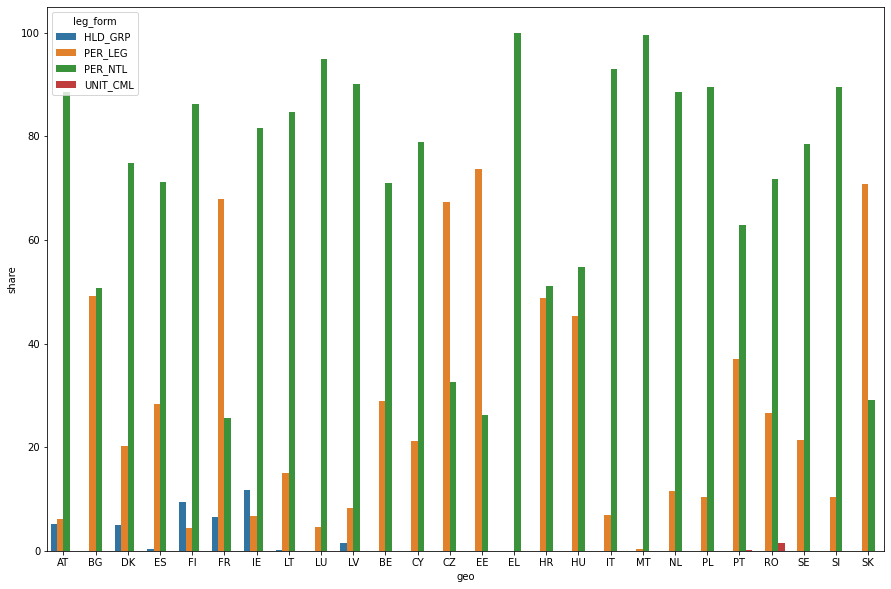

In [112]:
f, ax = plt.subplots(figsize = (15, 10))

sns.barplot(data = legal_form_join, x = 'geo', y = 'share', hue = 'leg_form')

plt.show()

In [113]:

legal_form_wide = legal_form_join.pivot(index = 'geo', columns = 'leg_form', values = 'share').reset_index()

null_share(legal_form_wide)

leg_form
geo          0.000000
HLD_GRP     69.230769
PER_LEG      0.000000
PER_NTL      0.000000
UNIT_CML    73.076923
dtype: float64

In [114]:
# As these are share which add up to 100%, the NaN values are actual zeroes so I'll replace them below

legal_form_clean = legal_form_wide.fillna(0)

legal_form_clean.head()

leg_form geo  HLD_GRP    PER_LEG    PER_NTL  UNIT_CML
0         AT  5.20902   6.193679  88.601697       0.0
1         BE  0.00000  28.993039  71.006961       0.0
2         BG  0.00000  49.275422  50.716297       0.0
3         CY  0.00000  21.151358  78.848642       0.0
4         CZ  0.00000  67.337921  32.662079       0.0

In [115]:

for col in legal_form_clean.select_dtypes(include = ['int', 'float']).columns:
    
    legal_form_clean[col] = legal_form_clean[col].apply(categorical_converter)


In [116]:
legal_form_clean.head()

leg_form geo   HLD_GRP   PER_LEG    PER_NTL  UNIT_CML
0         AT  very low  very low  very high  very low
1         BE  very low       low       high  very low
2         BG  very low    medium     medium  very low
3         CY  very low       low       high  very low
4         CZ  very low      high        low  very low

In [117]:
null_share(legal_form_clean)

leg_form
geo         0.0
HLD_GRP     0.0
PER_LEG     0.0
PER_NTL     0.0
UNIT_CML    0.0
dtype: float64

In [118]:
# Moving onto pesticides

In [119]:
pesticides = df_list[4]

In [120]:
pesticides.head()

Unnamed: 0 freq  crops pesticid unit geo\TIME_PERIOD  2010    2011  2012  \
0       27351    A  R1000        F   HA              CY   NaN  4277.0   NaN   
1       27352    A  R1000        F   HA              DK   NaN     NaN   NaN   
2       27353    A  R1000        F   HA              EL   NaN     NaN   NaN   
3       27354    A  R1000        F   HA              FR   NaN     NaN   NaN   
4       27355    A  R1000        F   HA              HR   NaN     NaN   NaN   

   2013  2014  2015  2016      2017  2018    2019  2020  
0   NaN   NaN   NaN   NaN       NaN   NaN  2838.0   NaN  
1   NaN   NaN   NaN   NaN  351583.0   NaN     NaN   NaN  
2   NaN   NaN   NaN   NaN       NaN   NaN     NaN   NaN  
3   NaN   NaN   NaN   NaN  172381.0   NaN     NaN   NaN  
4   NaN   NaN   NaN   NaN       NaN   NaN  9387.0   NaN

In [121]:
pesticides_df = rename_filter_drop(pesticides, 'geo\TIME_PERIOD', 'geo', 'geo', eu27_codes, ['Unnamed: 0', 'freq'])

In [122]:
pesticides_df.head()

crops pesticid unit geo  2010    2011  2012  2013  2014  2015  2016  \
0  R1000        F   HA  CY   NaN  4277.0   NaN   NaN   NaN   NaN   NaN   
1  R1000        F   HA  DK   NaN     NaN   NaN   NaN   NaN   NaN   NaN   
2  R1000        F   HA  EL   NaN     NaN   NaN   NaN   NaN   NaN   NaN   
3  R1000        F   HA  FR   NaN     NaN   NaN   NaN   NaN   NaN   NaN   
4  R1000        F   HA  HR   NaN     NaN   NaN   NaN   NaN   NaN   NaN   

       2017  2018    2019  2020  
0       NaN   NaN  2838.0   NaN  
1  351583.0   NaN     NaN   NaN  
2       NaN   NaN     NaN   NaN  
3  172381.0   NaN     NaN   NaN  
4       NaN   NaN  9387.0   NaN

In [123]:
pesticides_df.pesticid.unique()

array(['F', 'F01', 'F01_01', 'F01_02', 'F02', 'F02_02', 'F02_03', 'F03',
       'F03_01', 'F03_99', 'F04', 'F04_01', 'F04_02', 'F04_99', 'F05',
       'F05_01', 'F05_99', 'F99', 'F99_01', 'F99_02', 'F99_03', 'F99_05',
       'F99_06', 'F99_07', 'F99_08', 'F99_09', 'F99_10', 'F99_11',
       'F99_12', 'F99_13', 'F99_14', 'F99_15', 'F99_16', 'F99_17',
       'F99_99', 'H', 'H01', 'H01_01', 'H02', 'H02_02', 'H02_03', 'H03',
       'H03_01', 'H03_02', 'H03_03', 'H03_99', 'H04', 'H04_01', 'H05',
       'H05_01', 'H05_99', 'H06', 'H06_01', 'H06_02', 'H06_03', 'H06_99',
       'H99', 'H99_01', 'H99_02', 'H99_03', 'H99_04', 'H99_05', 'H99_07',
       'H99_08', 'H99_09', 'H99_11', 'H99_13', 'H99_14', 'H99_15',
       'H99_18', 'H99_19', 'H99_21', 'H99_22', 'H99_23', 'H99_24',
       'H99_25', 'H99_26', 'H99_99', 'I', 'I01', 'I01_01', 'I03',
       'I03_01', 'I03_02', 'I03_99', 'I04', 'I04_01', 'I04_99', 'I06',
       'I06_02', 'I99', 'I99_01', 'I99_03', 'I99_04', 'I99_05', 'I99_06',
       'I99

In [124]:
# Let's work with more aggregate data and filter for just the letter codes

pesticides_df = pesticides_df[pesticides_df.pesticid.str.isalpha()]

In [125]:
pesticides_df.head()

crops pesticid unit geo  2010    2011  2012  2013  2014  2015  2016  \
0  R1000        F   HA  CY   NaN  4277.0   NaN   NaN   NaN   NaN   NaN   
1  R1000        F   HA  DK   NaN     NaN   NaN   NaN   NaN   NaN   NaN   
2  R1000        F   HA  EL   NaN     NaN   NaN   NaN   NaN   NaN   NaN   
3  R1000        F   HA  FR   NaN     NaN   NaN   NaN   NaN   NaN   NaN   
4  R1000        F   HA  HR   NaN     NaN   NaN   NaN   NaN   NaN   NaN   

       2017  2018    2019  2020  
0       NaN   NaN  2838.0   NaN  
1  351583.0   NaN     NaN   NaN  
2       NaN   NaN     NaN   NaN  
3  172381.0   NaN     NaN   NaN  
4       NaN   NaN  9387.0   NaN

In [126]:
null_share(pesticides_df)

crops         0.000000
pesticid      0.000000
unit          0.000000
geo           0.000000
2010        100.000000
2011         93.478261
2012        100.000000
2013        100.000000
2014        100.000000
2015        100.000000
2016        100.000000
2017         56.521739
2018         67.391304
2019         69.565217
2020        100.000000
dtype: float64

In [127]:
# The null values seem to be very evenly spread across the different pesticides

grouped_null_counts(pesticides_df, 'pesticid')

crops  pesticid  unit  geo   2010   2011   2012   2013   2014  \
pesticid                                                                  
F           0.0       0.0   0.0  0.0  100.0   90.0  100.0  100.0  100.0   
H           0.0       0.0   0.0  0.0  100.0   90.0  100.0  100.0  100.0   
I           0.0       0.0   0.0  0.0  100.0   90.0  100.0  100.0  100.0   
M           0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0   
PGR         0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0   
ZR          0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0   

           2015   2016       2017       2018       2019   2020  
pesticid                                                        
F         100.0  100.0  60.000000  70.000000  70.000000  100.0  
H         100.0  100.0  60.000000  70.000000  60.000000  100.0  
I         100.0  100.0  60.000000  70.000000  70.000000  100.0  
M         100.0  100.0  50.000000  50.000000  75.000000  100.0  
PGR       100.0  100.0  40.000000  60.000000  80.000000  100.0  
ZR        100.0  100.0  57.142857  71.428571  71.428571  100.0

In [128]:
# Only a handful of countries have any data at all, I might have to ignore this as an explanatory variable
grouped_null_counts(pesticides_df, 'geo')

crops  pesticid  unit  geo   2010   2011   2012   2013   2014   2015  \
geo                                                                         
CY     0.0       0.0   0.0  0.0  100.0   25.0  100.0  100.0  100.0  100.0   
DK     0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0  100.0   
EL     0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0  100.0   
FR     0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0  100.0   
HR     0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0  100.0   
IT     0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0  100.0   
LU     0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0  100.0   
PL     0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0  100.0   
PT     0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0  100.0   
RO     0.0       0.0   0.0  0.0  100.0  100.0  100.0  100.0  100.0  100.0   

      2016   2017   2018   2019   2020  
geo                                     
CY   100.0  100.0  100.0    0.0  100.0  
DK   100.0    0.0  100.0  100.0  100.0  
EL   100.0  100.0  100.0   75.0  100.0  
FR   100.0    0.0  100.0  100.0  100.0  
HR   100.0  100.0  100.0    0.0  100.0  
IT   100.0  100.0    0.0    0.0  100.0  
LU   100.0  100.0    0.0  100.0  100.0  
PL   100.0    0.0  100.0  100.0  100.0  
PT   100.0    0.0  100.0  100.0  100.0  
RO   100.0  100.0    0.0  100.0  100.0

In [129]:
# Moving onto precipitation

In [130]:
precipitation = df_list[5]

In [131]:
precipitation.head()

Unnamed: 0  Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
0           0  1052.84   702.00    745.45  282.61          644.96   679.26   
1           1  1061.55   747.48    604.44  517.09          644.66   670.15   
2           2  1201.34   900.16    552.47  408.41          767.25   714.35   
3           3  1146.14   679.13    524.68  586.08          612.23   627.67   
4           4  1127.85   857.02    614.19  513.32          653.02   724.76   

   Denmark   Spain  Estonia  ...  Latvia   Malta  Netherlands  Poland  \
0   623.28  699.90   465.81  ...  544.84  532.05       703.74  593.49   
1   571.07  695.13   681.50  ...  679.59  517.00       653.14  602.83   
2   751.23  587.65   701.85  ...  734.96  357.54       847.83  654.05   
3   596.59  614.72   638.50  ...  661.88  589.99       610.09  531.73   
4   678.88  559.53   600.57  ...  654.59  500.78       752.95  648.97   

   Portugal  Romania  Slovakia  Slovenia  Sweden  Year  
0    861.43   746.83    776.19   1610.11  450.41  1901  
1    982.67   646.03    854.51   1414.19  531.58  1902  
2    857.42   545.30    891.52   1635.81  611.55  1903  
3    794.80   533.82    701.77   1531.75  521.95  1904  
4    713.31   621.53    799.35   1638.73  534.39  1905  

[5 rows x 29 columns]

In [132]:
eu_countries = {
    'Austria': 'AT',
    'Belgium': 'BE',
    'Bulgaria': 'BG',
    'Croatia': 'HR',
    'Cyprus': 'CY',
    'Czech Republic': 'CZ',
    'Denmark': 'DK',
    'Estonia': 'EE',
    'Finland': 'FI',
    'France': 'FR',
    'Germany': 'DE',
    'Greece': 'GR',
    'Hungary': 'HU',
    'Ireland': 'IE',
    'Italy': 'IT',
    'Latvia': 'LV',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Malta': 'MT',
    'Netherlands': 'NL',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Romania': 'RO',
    'Slovakia': 'SK',
    'Slovenia': 'SI',
    'Spain': 'ES',
    'Sweden': 'SE',
}


In [133]:
precipitation.rename(columns = eu_countries, inplace = True)

In [134]:
precipitation.head()

Unnamed: 0       AT      BE      BG      CY      CZ      DE      DK  \
0           0  1052.84  702.00  745.45  282.61  644.96  679.26  623.28   
1           1  1061.55  747.48  604.44  517.09  644.66  670.15  571.07   
2           2  1201.34  900.16  552.47  408.41  767.25  714.35  751.23   
3           3  1146.14  679.13  524.68  586.08  612.23  627.67  596.59   
4           4  1127.85  857.02  614.19  513.32  653.02  724.76  678.88   

       ES      EE  ...      LV      MT      NL      PL      PT      RO  \
0  699.90  465.81  ...  544.84  532.05  703.74  593.49  861.43  746.83   
1  695.13  681.50  ...  679.59  517.00  653.14  602.83  982.67  646.03   
2  587.65  701.85  ...  734.96  357.54  847.83  654.05  857.42  545.30   
3  614.72  638.50  ...  661.88  589.99  610.09  531.73  794.80  533.82   
4  559.53  600.57  ...  654.59  500.78  752.95  648.97  713.31  621.53   

       SK       SI      SE  Year  
0  776.19  1610.11  450.41  1901  
1  854.51  1414.19  531.58  1902  
2  891.52  1635.81  611.55  1903  
3  701.77  1531.75  521.95  1904  
4  799.35  1638.73  534.39  1905  

[5 rows x 29 columns]

In [135]:
precipitation_df_long = precipitation.drop(columns = 'Unnamed: 0').melt(id_vars = 'Year', var_name = 'geo')

In [136]:
precipitation_df_long.head()

Year geo    value
0  1901  AT  1052.84
1  1902  AT  1061.55
2  1903  AT  1201.34
3  1904  AT  1146.14
4  1905  AT  1127.85

In [137]:
precipitation_df_long.tail()

Year geo   value
3262  2017  SE  678.22
3263  2018  SE  539.63
3264  2019  SE  682.36
3265  2020  SE  669.34
3266  2021  SE  608.87

In [138]:
# Let's get the mean for each country and graph it so we get a sense of how precipitation varies across countries

precipitation_df_long_mean = precipitation_df_long.groupby('geo').value.mean().sort_values()

In [139]:
precipitation_df_long_mean.head()

geo
MT    481.637851
CY    484.614298
FI    557.877273
PL    609.667934
SE    610.025124
Name: value, dtype: float64

In [140]:
type(precipitation_df_long_mean)

pandas.core.series.Series

Text(0.5, 1.0, 'Average Annual Rainfall: 1901-2021')

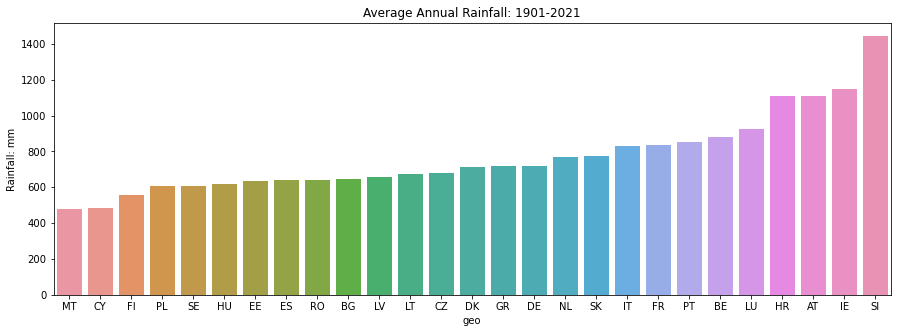

In [141]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.barplot(x = precipitation_df_long_mean.index, y = precipitation_df_long_mean.values)

plt.ylabel('Rainfall: mm')
plt.title('Average Annual Rainfall: 1901-2021')

In [142]:
# Converting Year to a string for the purpose of joining to yields data where the Year is a string

precipitation_clean = precipitation_df_long.rename(columns = {'value': 'Precipitation'})
precipitation_clean['Year'] = precipitation_clean.Year.astype('str')

In [143]:
precipitation_clean.head()

Year geo  Precipitation
0  1901  AT        1052.84
1  1902  AT        1061.55
2  1903  AT        1201.34
3  1904  AT        1146.14
4  1905  AT        1127.85

In [144]:
# Now soil erosion

In [145]:
soil_erosion = df_list[6]

In [146]:
soil_erosion.head()

Unnamed: 0 freq levels    clc18  unit geo\TIME_PERIOD  2000  2010  2016
0      112815    A  TOTAL  CLC2X23  T_HA              AT   5.3   5.0   4.9
1      112816    A  TOTAL  CLC2X23  T_HA            AT11   3.5   2.9   2.8
2      112817    A  TOTAL  CLC2X23  T_HA           AT111   4.3   3.3   3.1
3      112818    A  TOTAL  CLC2X23  T_HA           AT112   1.6   1.3   1.2
4      112819    A  TOTAL  CLC2X23  T_HA           AT113   6.0   5.1   4.9

In [147]:
soil_erosion_df = rename_filter_drop(soil_erosion, 'geo\TIME_PERIOD', 'geo', 'geo', eu27_codes, ['Unnamed: 0', 'freq'])

In [148]:
soil_erosion_df.head()

levels    clc18  unit geo  2000  2010  2016
0    TOTAL  CLC2X23  T_HA  AT   5.3   5.0   4.9
45   TOTAL  CLC2X23  T_HA  BE   2.1   1.7   1.7
101  TOTAL  CLC2X23  T_HA  BG   4.1   3.1   3.4
136  TOTAL  CLC2X23  T_HA  CY   4.3   3.6   3.7
139  TOTAL  CLC2X23  T_HA  CZ   3.3   2.7   2.7

In [149]:
# There are no missing values

null_share(soil_erosion_df)

levels    0.0
clc18     0.0
unit      0.0
geo       0.0
2000      0.0
2010      0.0
2016      0.0
dtype: float64

In [150]:
# Let's plot the data to get a feel for it
# First of all let's produce a long dataset

soil_erosion_df_long = soil_erosion_df.melt(id_vars = ['levels', 'clc18', 'unit', 'geo'], var_name = 'Year')


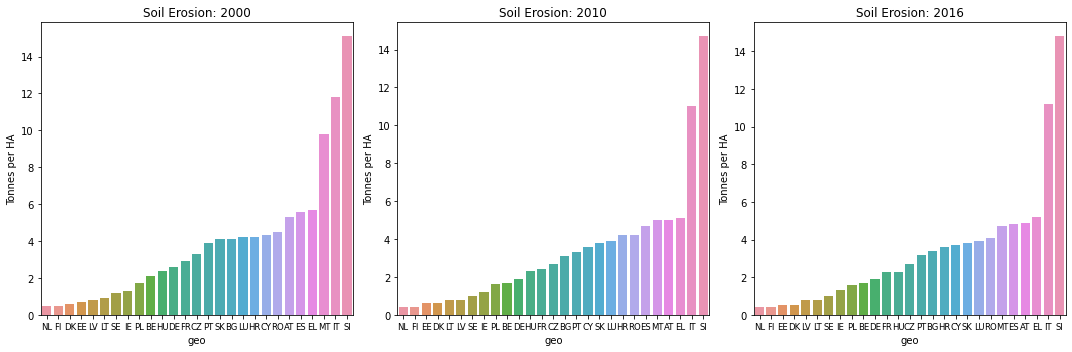

In [151]:
# I seemed to have used this for loop structure a few times, can I package this into a funtion?

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i, year in enumerate(soil_erosion_df_long.Year.unique()):
    
    soil_erosion_graph_data = soil_erosion_df_long[soil_erosion_df_long.Year == year].sort_values(by = 'value')
    
    sns.barplot(data = soil_erosion_graph_data, x = 'geo', y = 'value', ax = ax[i])
    
    ax[i].set_title(f'Soil Erosion: {year}')
    
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize = 8.5)
    
    ax[i].set_ylabel('Tonnes per HA')
    
    
    
    
plt.tight_layout()



In [152]:
# From visual inspection, soil erosion is fairly consistent across countries and time
# Given this and that I only have data for 3 years, I'll average across the years
# and convert this to categorical data

In [153]:
soil_erosion_df_long.head()

levels    clc18  unit geo  Year  value
0  TOTAL  CLC2X23  T_HA  AT  2000    5.3
1  TOTAL  CLC2X23  T_HA  BE  2000    2.1
2  TOTAL  CLC2X23  T_HA  BG  2000    4.1
3  TOTAL  CLC2X23  T_HA  CY  2000    4.3
4  TOTAL  CLC2X23  T_HA  CZ  2000    3.3

In [154]:
soil_erosion_mean = soil_erosion_df_long.groupby(['clc18', 'unit', 'geo']).mean().reset_index()

In [155]:
# To apply my categorical_converter function, I need the data to be scaled so it's between 0 and 100
# I'll use the sklearn.preprocessing to do this

scaler = MinMaxScaler(feature_range = (0, 100))

soil_erosion_mean['value_scaled'] = scaler.fit_transform(soil_erosion_mean[['value']])

soil_erosion_mean['soil_erosion'] = soil_erosion_mean.value_scaled.apply(categorical_converter)


In [156]:
soil_erosion_mean.head()

clc18  unit geo     value  value_scaled soil_erosion
0  CLC2X23  T_HA  AT  5.066667     32.101617          low
1  CLC2X23  T_HA  BE  1.833333      9.699769     very low
2  CLC2X23  T_HA  BG  3.533333     21.478060          low
3  CLC2X23  T_HA  CY  3.866667     23.787529          low
4  CLC2X23  T_HA  CZ  2.900000     17.090069     very low

In [157]:
soil_erosion_mean.groupby('soil_erosion').count()

clc18  unit  geo  value  value_scaled
soil_erosion                                       
high              1     1    1      1             1
low              10    10   10     10            10
medium            1     1    1      1             1
very high         1     1    1      1             1
very low         14    14   14     14            14

In [158]:
soil_erosion_clean = soil_erosion_mean.drop(columns = ['clc18', 'unit', 'value', 'value_scaled'])

In [159]:
soil_erosion_clean.head()

geo soil_erosion
0  AT          low
1  BE     very low
2  BG          low
3  CY          low
4  CZ     very low

In [160]:
# Next up is temperature

In [161]:
temperature = df_list[7]

In [162]:
temperature.head()

Unnamed: 0  Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
0           0     5.41     8.89     10.42   17.91            6.76     7.86   
1           1     5.34     8.52      9.78   17.46            6.23     7.37   
2           2     5.88     9.40     10.71   16.69            7.38     8.43   
3           3     6.22     9.38     10.22   17.06            7.51     8.50   
4           4     5.79     9.03     10.41   17.35            7.15     8.09   

   Denmark  Spain  Estonia  ...  Latvia  Malta  Netherlands  Poland  Portugal  \
0     7.73  12.21     5.38  ...    6.03  18.29         8.87    7.74     14.15   
1     6.45  12.42     3.00  ...    3.96  18.40         8.30    6.31     14.27   
2     7.67  12.48     5.82  ...    6.46  18.00         9.40    8.11     14.45   
3     7.54  12.86     4.14  ...    4.92  18.29         9.30    7.47     14.78   
4     7.61  12.23     5.18  ...    5.76  18.02         9.01    7.69     14.13   

   Romania  Slovakia  Slovenia  Sweden  Year  
0     9.17      7.45      7.79    2.32  1901  
1     8.27      6.57      7.78    0.29  1902  
2     9.53      7.90      8.28    2.11  1903  
3     8.91      7.71      8.65    1.28  1904  
4     9.14      7.60      8.13    1.92  1905  

[5 rows x 29 columns]

In [163]:
temperature.rename(columns = eu_countries, inplace = True)
temperature.drop(columns = 'Unnamed: 0', inplace = True)

In [164]:
temperature.head()

AT    BE     BG     CY    CZ    DE    DK     ES    EE    FI  ...    LV  \
0  5.41  8.89  10.42  17.91  6.76  7.86  7.73  12.21  5.38  1.50  ...  6.03   
1  5.34  8.52   9.78  17.46  6.23  7.37  6.45  12.42  3.00 -1.11  ...  3.96   
2  5.88  9.40  10.71  16.69  7.38  8.43  7.67  12.48  5.82  1.65  ...  6.46   
3  6.22  9.38  10.22  17.06  7.51  8.50  7.54  12.86  4.14  0.29  ...  4.92   
4  5.79  9.03  10.41  17.35  7.15  8.09  7.61  12.23  5.18  1.26  ...  5.76   

      MT    NL    PL     PT    RO    SK    SI    SE  Year  
0  18.29  8.87  7.74  14.15  9.17  7.45  7.79  2.32  1901  
1  18.40  8.30  6.31  14.27  8.27  6.57  7.78  0.29  1902  
2  18.00  9.40  8.11  14.45  9.53  7.90  8.28  2.11  1903  
3  18.29  9.30  7.47  14.78  8.91  7.71  8.65  1.28  1904  
4  18.02  9.01  7.69  14.13  9.14  7.60  8.13  1.92  1905  

[5 rows x 28 columns]

In [165]:
temperature_df_long = temperature.melt(id_vars = 'Year', var_name = 'geo')

In [166]:
temperature_df_long.head()

Year geo  value
0  1901  AT   5.41
1  1902  AT   5.34
2  1903  AT   5.88
3  1904  AT   6.22
4  1905  AT   5.79

In [167]:
# There are no missing values

null_share(temperature_df_long)

Year     0.0
geo      0.0
value    0.0
dtype: float64

C:\Users\justi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Degrees Celsius')

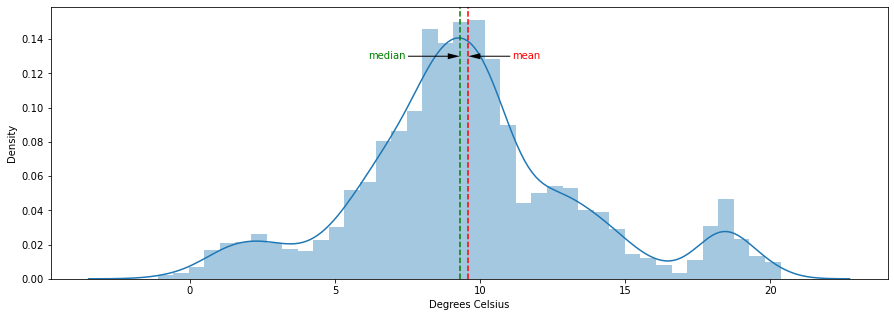

In [168]:
# The data is not exactly normal, it's skewed to the right as can clearly be seen by the mean being above the median
# I should reproduce this for the precipitation data

plt.subplots(figsize = (15, 5))

sns.distplot(temperature_df_long.value, kde = True)

mean_val = temperature_df_long.value.mean()
median_val = temperature_df_long.value.median()

plt.axvline(mean_val, linestyle = 'dashed', color = 'red')
plt.annotate('mean', xy = (mean_val, 0.13), xytext = (mean_val + 2, 0.13),
            arrowprops = dict(facecolor = 'black', edgecolor = 'none', width = 1, headwidth = 6),
            ha = 'center', va = 'center', color = 'red')

plt.axvline(median_val, linestyle = 'dashed', color = 'green')
plt.annotate('median', xy = (median_val, 0.13), xytext = (median_val - 2.5, 0.13),
            arrowprops = dict(facecolor = 'black', edgecolor = 'none', width = 1, headwidth = 6),
            ha = 'center', va = 'center', color = 'green')

plt.xlabel('Degrees Celsius')



In [169]:
# Let's get the median temperature for each country and graph it to get a feel for the data
# I'm using the median because the data is slightly skewed

temperature_med = temperature_df_long.groupby('geo').value.median().reset_index().sort_values(by = 'value')

Text(0.5, 1.0, 'Median Temperature: 1901-2021')

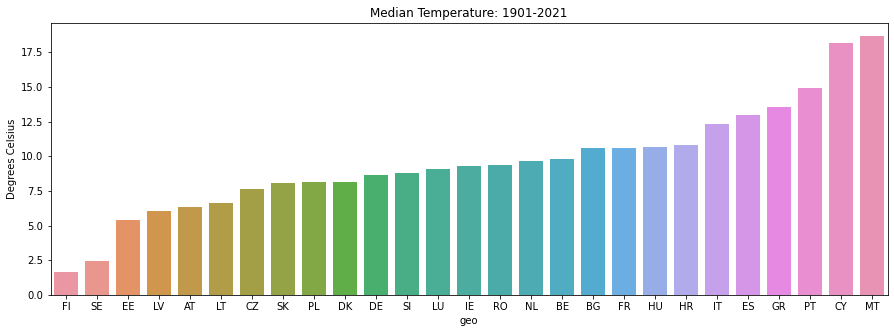

In [170]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.barplot(data = temperature_med, x = 'geo', y = 'value')

plt.ylabel('Degrees Celsius')
plt.title('Median Temperature: 1901-2021')

In [171]:
temperature_med.head()

geo  value
9   FI   1.62
24  SE   2.46
7   EE   5.43
18  LV   6.06
0   AT   6.32

In [55]:
eu_codes = {'AT': 'AUT', 'BE': 'BEL', 'BG': 'BGR', 'CY': 'CYP', 'CZ': 'CZE', 'DE': 'DEU', 'DK': 'DNK', 'EE': 'EST', 
            'ES': 'ESP', 'FI': 'FIN', 'FR': 'FRA', 'GR': 'GRC', 'HR': 'HRV', 'HU': 'HUN', 'IE': 'IRL', 'IT': 'ITA', 
            'LT': 'LTU', 'LU': 'LUX', 'LV': 'LVA', 'MT': 'MLT', 'NL': 'NLD', 'PL': 'POL', 'PT': 'PRT', 'RO': 'ROU', 
            'SE': 'SWE', 'SI': 'SVN', 'SK': 'SVK'}


temperature_med.geo.replace(eu_codes, inplace = True)

In [173]:
temperature_med.head()

geo  value
9   FIN   1.62
24  SWE   2.46
7   EST   5.43
18  LVA   6.06
0   AUT   6.32

In [174]:
fig = px.choropleth(temperature_med, locations = 'geo', color = 'value', color_continuous_scale = px.colors.sequential.Plasma)
fig.update_layout(geo_scope = 'europe', title_text = 'Median Annual Temperate (Degrees Celsius): 1901-2021')
fig.show()

In [175]:
temperature_clean = temperature_df_long.rename(columns = {'value': 'Temperature'})
temperature_clean['Year'] = temperature_clean.Year.astype('str')

In [176]:
temperature_clean.head()

Year geo  Temperature
0  1901  AT         5.41
1  1902  AT         5.34
2  1903  AT         5.88
3  1904  AT         6.22
4  1905  AT         5.79

In [177]:
# Next up is tenure status

In [178]:
tenure_status = df_list[8]

In [179]:
tenure_status.head()

Unnamed: 0 freq tenure    age sex farmtype agrarea unit geo\TIME_PERIOD  \
0      308784    A    CML  TOTAL   T  FT16_SO   TOTAL   HA              AT   
1      308785    A    CML  TOTAL   T  FT16_SO   TOTAL   HA            AT11   
2      308786    A    CML  TOTAL   T  FT16_SO   TOTAL   HA            AT12   
3      308787    A    CML  TOTAL   T  FT16_SO   TOTAL   HA            AT13   
4      308788    A    CML  TOTAL   T  FT16_SO   TOTAL   HA            AT21   

   2013      2016  
0   NaN  187410.0  
1   NaN     300.0  
2   NaN    2750.0  
3   NaN       0.0  
4   NaN   26600.0

In [180]:
tenure_status_df = rename_filter_drop(tenure_status, 'geo\TIME_PERIOD', 'geo', 'geo', eu27_codes, ['Unnamed: 0', 'freq'])

In [181]:
tenure_status_df.head()

tenure    age sex farmtype agrarea unit geo  2013      2016
0     CML  TOTAL   T  FT16_SO   TOTAL   HA  AT   NaN  187410.0
10    CML  TOTAL   T  FT16_SO   TOTAL   HA  BE   NaN       0.0
22    CML  TOTAL   T  FT16_SO   TOTAL   HA  BG   NaN  696330.0
29    CML  TOTAL   T  FT16_SO   TOTAL   HA  CY   NaN       NaN
31    CML  TOTAL   T  FT16_SO   TOTAL   HA  CZ   NaN       0.0

In [182]:
# There are a lot of null values in 2013. As we just have 2 years of data, I'll again turn this into a categorical predictor
# based on the 2016 data unless there's missing data for 2016 that's available for 2013. I think this is reasonable seen as 
# tenure status is not something which would change significantly over short periods of time

null_share(tenure_status_df)

tenure       0.000000
age          0.000000
sex          0.000000
farmtype     0.000000
agrarea      0.000000
unit         0.000000
geo          0.000000
2013        25.000000
2016         0.925926
dtype: float64

In [183]:
grouped_null_counts(tenure_status_df, 'tenure')

tenure  age  sex  farmtype  agrarea  unit  geo   2013      2016
tenure                                                                  
CML         0.0  0.0  0.0       0.0      0.0   0.0  0.0  100.0  3.703704
OWN         0.0  0.0  0.0       0.0      0.0   0.0  0.0    0.0  0.000000
RENT        0.0  0.0  0.0       0.0      0.0   0.0  0.0    0.0  0.000000
SHR_OTH     0.0  0.0  0.0       0.0      0.0   0.0  0.0    0.0  0.000000

In [184]:
tenure_status_df['value'] = np.where(tenure_status_df['2016'].isnull(), tenure_status_df['2013'], tenure_status_df['2016'])

In [185]:
# It would appear from the below that 2013 wasn't able to fill any gaps in the 2016 data

null_share(tenure_status_df)

tenure       0.000000
age          0.000000
sex          0.000000
farmtype     0.000000
agrarea      0.000000
unit         0.000000
geo          0.000000
2013        25.000000
2016         0.925926
value        0.925926
dtype: float64

In [186]:
# I want total tenure and then I can define the different types as shares of the total

tenure_status_total = tenure_status_df.groupby('geo').value.sum().reset_index()

In [187]:
tenure_status_total.head()

geo      value
0  AT   561710.0
1  BE   310760.0
2  BG  1023830.0
3  CY    23600.0
4  CZ   278220.0

In [188]:
# Now I want to join these total figures onto the the full dataset and calclate shares
# As the data are shares, NaN's can be replaced with 0

tenure_status_join = pd.merge(tenure_status_df, tenure_status_total, on = 'geo', how = 'left', suffixes = ('', '_total'))

tenure_status_join['share'] = tenure_status_join.value.div(tenure_status_join.value_total).mul(100)

tenure_status_join.fillna(0, inplace = True)

In [189]:
tenure_status_join.head()

tenure    age sex farmtype agrarea unit geo  2013      2016     value  \
0    CML  TOTAL   T  FT16_SO   TOTAL   HA  AT   0.0  187410.0  187410.0   
1    CML  TOTAL   T  FT16_SO   TOTAL   HA  BE   0.0       0.0       0.0   
2    CML  TOTAL   T  FT16_SO   TOTAL   HA  BG   0.0  696330.0  696330.0   
3    CML  TOTAL   T  FT16_SO   TOTAL   HA  CY   0.0       0.0       0.0   
4    CML  TOTAL   T  FT16_SO   TOTAL   HA  CZ   0.0       0.0       0.0   

   value_total      share  
0     561710.0  33.364191  
1     310760.0   0.000000  
2    1023830.0  68.012268  
3      23600.0   0.000000  
4     278220.0   0.000000

In [190]:
len(tenure_status_join.tenure.unique())

4

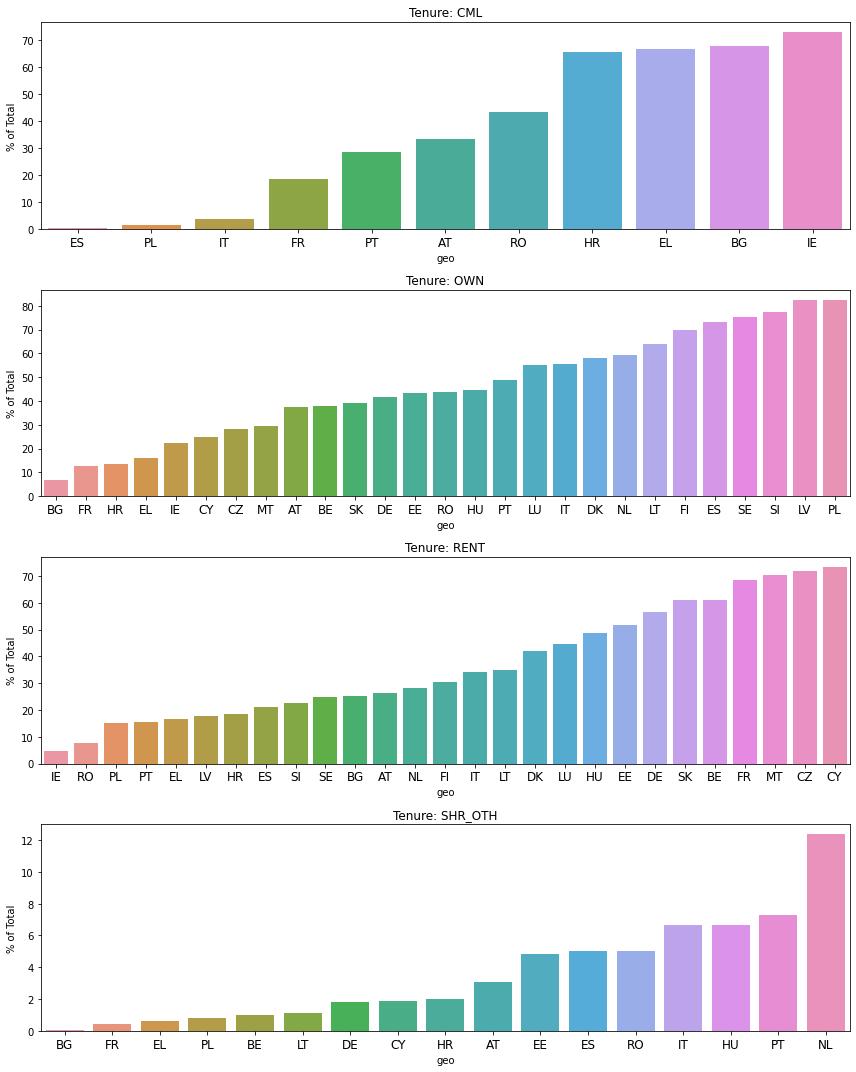

In [191]:
# I seemed to have used this for loop structure a few times, can I package this into a funtion?
# I should remove the filtering for non-zeroes to being outside the graphing code so it's still standard

fig, ax = plt.subplots(tenure_status_join.tenure.unique().size, 1, figsize = (12, 15))

for i, tenure in enumerate(tenure_status_join.tenure.unique()):
    
    tenure_graph_data = tenure_status_join[(tenure_status_join.tenure == tenure) & 
                                           (tenure_status_join.share != 0)].sort_values(by = 'share')
    
    sns.barplot(data = tenure_graph_data, x = 'geo', y = 'share', ax = ax[i])
    
    ax[i].set_title(f'Tenure: {tenure}')
    
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize = 12)
    
    ax[i].set_ylabel('% of Total')
    
    
    
    
plt.tight_layout()

In [192]:
tenure_status_wide = tenure_status_join.pivot(index = 'geo', columns = 'tenure', values = 'share').reset_index()

In [193]:
tenure_status_wide.head()

tenure geo        CML        OWN       RENT   SHR_OTH
0       AT  33.364191  37.421445  26.152285  3.062078
1       BE   0.000000  38.055091  60.957009  0.987901
2       BG  68.012268   6.652472  25.314750  0.020511
3       CY   0.000000  24.703390  73.432203  1.864407
4       CZ   0.000000  28.301344  71.698656  0.000000

In [194]:
null_share(tenure_status_wide)

tenure
geo        0.0
CML        0.0
OWN        0.0
RENT       0.0
SHR_OTH    0.0
dtype: float64

In [195]:
# This for loop structure is another pattern I've used quite a bit, could I wrap it into a function?

for col in tenure_status_wide.select_dtypes(include = ['int', 'float']).columns:
    
    tenure_status_wide[col] = tenure_status_wide[col].apply(categorical_converter)

tenure_status_wide.head()

tenure geo       CML       OWN  RENT   SHR_OTH
0       AT       low       low   low  very low
1       BE  very low       low  high  very low
2       BG      high  very low   low  very low
3       CY  very low       low  high  very low
4       CZ  very low       low  high  very low

In [196]:
tenure_status_clean = tenure_status_wide

In [197]:
# Now moving onto training

In [198]:
training = df_list[9]

In [199]:
training.head()

Unnamed: 0 freq training    age sex so_eur agrarea unit geo\TIME_PERIOD  \
0      145156    A    BASIC  TOTAL   T  TOTAL   TOTAL   HA              AT   
1      145157    A    BASIC  TOTAL   T  TOTAL   TOTAL   HA            AT11   
2      145158    A    BASIC  TOTAL   T  TOTAL   TOTAL   HA            AT12   
3      145159    A    BASIC  TOTAL   T  TOTAL   TOTAL   HA            AT13   
4      145160    A    BASIC  TOTAL   T  TOTAL   TOTAL   HA            AT21   

       2013      2016  
0  686840.0  691450.0  
1   36040.0   37840.0  
2  220350.0  243110.0  
3    1660.0    1400.0  
4   58210.0   47220.0

In [200]:
training_df = rename_filter_drop(training, 'geo\TIME_PERIOD', 'geo', 'geo', eu27_codes, ['Unnamed: 0', 'freq'])

In [201]:
training_df.head()

training    age sex so_eur agrarea unit geo      2013      2016
0     BASIC  TOTAL   T  TOTAL   TOTAL   HA  AT  686840.0  691450.0
10    BASIC  TOTAL   T  TOTAL   TOTAL   HA  BE  278590.0  428150.0
22    BASIC  TOTAL   T  TOTAL   TOTAL   HA  BG  135890.0  327040.0
29    BASIC  TOTAL   T  TOTAL   TOTAL   HA  CY   15720.0   57170.0
31    BASIC  TOTAL   T  TOTAL   TOTAL   HA  CZ  283850.0  262560.0

In [202]:
# There's no missing data in 2016, seen as I only have data for two years, I'll again turn this into a categorical variable
# just using the data from 2016

null_share(training_df)

training    0.000000
age         0.000000
sex         0.000000
so_eur      0.000000
agrarea     0.000000
unit        0.000000
geo         0.000000
2013        8.474576
2016        0.000000
dtype: float64

In [203]:
# There is a total figure so I don't need to calculate it, it adds up to the sub components to wihtin a bit of rounding

training_df.training.unique()

array(['BASIC', 'FULL', 'NAP', 'PRACT', 'TOTAL'], dtype=object)

In [204]:
training_df_total = training_df[training_df.training == 'TOTAL']

training_df_total.head()

training    age sex so_eur agrarea unit geo       2013       2016
1099    TOTAL  TOTAL   T  TOTAL   TOTAL   HA  AT  2726890.0  2669750.0
1109    TOTAL  TOTAL   T  TOTAL   TOTAL   HA  BE  1307900.0  1354250.0
1121    TOTAL  TOTAL   T  TOTAL   TOTAL   HA  BG  4650940.0  4491860.0
1128    TOTAL  TOTAL   T  TOTAL   TOTAL   HA  CY   109330.0   111930.0
1130    TOTAL  TOTAL   T  TOTAL   TOTAL   HA  CZ  3491470.0  3455410.0

In [205]:
training_df_join = pd.merge(training_df, training_df_total, on = ['age', 'sex', 'so_eur', 'agrarea', 'unit', 'geo'], 
                            how = 'left', suffixes = ('', '_total'))

training_df_join['share'] = training_df_join['2016'].div(training_df_join['2016_total']).mul(100)

training_df_join = training_df_join[training_df_join.training != 'TOTAL']

training_df_join.head()

training    age sex so_eur agrarea unit geo      2013      2016  \
0    BASIC  TOTAL   T  TOTAL   TOTAL   HA  AT  686840.0  691450.0   
1    BASIC  TOTAL   T  TOTAL   TOTAL   HA  BE  278590.0  428150.0   
2    BASIC  TOTAL   T  TOTAL   TOTAL   HA  BG  135890.0  327040.0   
3    BASIC  TOTAL   T  TOTAL   TOTAL   HA  CY   15720.0   57170.0   
4    BASIC  TOTAL   T  TOTAL   TOTAL   HA  CZ  283850.0  262560.0   

  training_total  2013_total  2016_total      share  
0          TOTAL   2726890.0   2669750.0  25.899429  
1          TOTAL   1307900.0   1354250.0  31.615285  
2          TOTAL   4650940.0   4491860.0   7.280726  
3          TOTAL    109330.0    111930.0  51.076566  
4          TOTAL   3491470.0   3455410.0   7.598519

In [206]:
# Theses are shares so again I can replace NaN values with 0's

training_clean = training_df_join[['training', 'geo', 'share']].pivot(index = ['geo'], columns = 'training', 
                                                                         values = 'share').reset_index().fillna(0)

In [207]:
training_clean.head()

training geo      BASIC       FULL        NAP      PRACT
0         AT  25.899429  37.823392   7.054968  29.221837
1         BE  31.615285  26.384346   0.000000  42.000369
2         BG   7.280726  28.832822  15.502041  48.384634
3         CY  51.076566   2.975074   0.000000  45.939426
4         CZ   7.598519  80.147942   0.000000  12.253249

In [208]:
# Now I'll convert to a categorical variable with my categorical converter function
# I'm using a for loop here because I need to apply it to only numerical columns

for col in training_clean.select_dtypes(include = ['int', 'float']).columns:
    
    training_clean[col] = training_clean[col].apply(categorical_converter)



In [209]:
training_clean.head()

training geo     BASIC       FULL       NAP     PRACT
0         AT       low        low  very low       low
1         BE       low        low  very low    medium
2         BG  very low        low  very low    medium
3         CY    medium   very low  very low    medium
4         CZ  very low  very high  very low  very low

In [210]:
# Now to look at yields again


In [31]:
yields = df_list[10]

In [32]:
yields.head()

Unnamed: 0 freq  crops  strucpro geo\TIME_PERIOD  2000  2001  2002  2003  \
0         246    A  C0000  YI_HU_EU              AT   NaN   NaN   NaN   NaN   
1         247    A  C0000  YI_HU_EU              BG   NaN   NaN   NaN   NaN   
2         248    A  C0000  YI_HU_EU              CH   NaN   NaN   NaN   NaN   
3         249    A  C0000  YI_HU_EU              CY   NaN   NaN   NaN   NaN   
4         250    A  C0000  YI_HU_EU              CZ   NaN   NaN   NaN   NaN   

   2004  ...  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  
0   NaN  ...  5.85  7.06   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN  ...  4.67  4.93   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN  ...  1.69  0.28   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   NaN  ...  5.32  6.23   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 28 columns]

In [33]:
yields_df = rename_filter_drop(yields, 'geo\TIME_PERIOD', 'geo', 'geo', eu27_codes, ['Unnamed: 0', 'freq'])

In [34]:
yields_df.head()

crops  strucpro geo  2000  2001  2002  2003  2004  2005  2006  ...  2013  \
0  C0000  YI_HU_EU  AT   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...  5.85   
1  C0000  YI_HU_EU  BG   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...  4.67   
3  C0000  YI_HU_EU  CY   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...  1.69   
4  C0000  YI_HU_EU  CZ   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...  5.32   
5  C0000  YI_HU_EU  DE   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...  7.32   

   2014  2015  2016  2017  2018  2019  2020  2021  2022  
0  7.06   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1  4.93   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3  0.28   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4  6.23   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5  8.05   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 26 columns]

In [35]:
null_share(yields_df)

crops        0.000000
strucpro     0.000000
geo          0.000000
2000        81.428571
2001        81.339286
2002        81.160714
2003        81.160714
2004        77.410714
2005        77.500000
2006        77.500000
2007        77.500000
2008        76.607143
2009        76.607143
2010        33.571429
2011        34.017857
2012        34.642857
2013        35.178571
2014        31.785714
2015        21.785714
2016        20.357143
2017        23.035714
2018        20.535714
2019        21.607143
2020        18.392857
2021        20.803571
2022        35.982143
dtype: float64

In [36]:
grouped_null_counts(yields_df, 'crops')

crops  strucpro  geo        2000        2001        2002  \
crops                                                                  
C0000         0.0       0.0  0.0  100.000000  100.000000  100.000000   
C1000         0.0       0.0  0.0  100.000000  100.000000  100.000000   
C1100         0.0       0.0  0.0   73.076923   73.076923   73.076923   
C1110         0.0       0.0  0.0   76.923077   76.923077   76.923077   
C1111         0.0       0.0  0.0   76.923077   76.923077   76.923077   
C1112         0.0       0.0  0.0   82.608696   82.608696   82.608696   
C1120         0.0       0.0  0.0   80.000000   80.000000   80.000000   
C1200         0.0       0.0  0.0   75.000000   75.000000   75.000000   
C1210         0.0       0.0  0.0   75.000000   75.000000   75.000000   
C1220         0.0       0.0  0.0  100.000000  100.000000  100.000000   
C1300         0.0       0.0  0.0   73.076923   73.076923   73.076923   
C1310         0.0       0.0  0.0   80.000000   80.000000   80.000000   
C1320         0.0       0.0  0.0   83.333333   83.333333   83.333333   
C1400         0.0       0.0  0.0   73.076923   73.076923   73.076923   
C1410         0.0       0.0  0.0   73.076923   73.076923   73.076923   
C1420         0.0       0.0  0.0   83.333333   83.333333   83.333333   
C1500         0.0       0.0  0.0   81.818182   81.818182   81.818182   
C1600         0.0       0.0  0.0   84.000000   84.000000   84.000000   
C1700         0.0       0.0  0.0   84.615385   84.615385   84.615385   
C1900         0.0       0.0  0.0   77.272727   77.272727   77.272727   
C2000         0.0       0.0  0.0   62.500000   62.500000   62.500000   
C2100         0.0       0.0  0.0   57.142857   57.142857   57.142857   
C2200         0.0       0.0  0.0   62.500000   62.500000   62.500000   
G0000         0.0       0.0  0.0   80.000000   80.000000   80.000000   
G1000         0.0       0.0  0.0   85.000000   85.000000   85.000000   
G2000         0.0       0.0  0.0   85.714286   85.714286   85.714286   
G2100         0.0       0.0  0.0   84.210526   84.210526   84.210526   
G2900         0.0       0.0  0.0   88.888889   88.888889   88.888889   
G3000         0.0       0.0  0.0   80.000000   80.000000   80.000000   
G9100         0.0       0.0  0.0   83.333333   83.333333   83.333333   
G9900         0.0       0.0  0.0   88.888889   88.888889   88.888889   
I0000         0.0       0.0  0.0  100.000000  100.000000  100.000000   
I1100         0.0       0.0  0.0   75.000000   70.833333   70.833333   
I1110         0.0       0.0  0.0   75.000000   75.000000   75.000000   
I1110-1130    0.0       0.0  0.0   72.000000   72.000000   72.000000   
I1111         0.0       0.0  0.0   83.333333   83.333333   83.333333   
I1112         0.0       0.0  0.0   88.235294   88.235294   88.235294   
I1120         0.0       0.0  0.0   76.470588   76.470588   76.470588   
I1130         0.0       0.0  0.0   82.352941   82.352941   82.352941   
I1140         0.0       0.0  0.0   89.473684   89.473684   89.473684   
I1150         0.0       0.0  0.0   87.500000   87.500000   87.500000   
I1190         0.0       0.0  0.0   94.736842   94.736842   84.210526   
I2100         0.0       0.0  0.0   87.500000   87.500000   87.500000   
I2200         0.0       0.0  0.0   93.750000   93.750000   93.750000   
I2300         0.0       0.0  0.0   66.666667   66.666667   66.666667   
I2900         0.0       0.0  0.0  100.000000  100.000000  100.000000   
I3000         0.0       0.0  0.0   69.230769   69.230769   69.230769   
I4000         0.0       0.0  0.0   84.615385   84.615385   84.615385   
I5000         0.0       0.0  0.0   78.947368   78.947368   78.947368   
I6000         0.0       0.0  0.0  100.000000  100.000000  100.000000   
P0000         0.0       0.0  0.0  100.000000  100.000000  100.000000   
P1100         0.0       0.0  0.0   76.000000   76.000000   76.000000   
P1200         0.0       0.0  0.0   76.923077   76.923077   76.923077   
P1300         0.0       0.0  0.0   87.500000   87.50

In [37]:
potato_yields = yields_df[yields_df.crops == 'R1000']

In [38]:
potato_yields.head()

crops  strucpro geo  2000  2001  2002  2003   2004   2005   2006  ...  \
1409  R1000  YI_HU_EU  AT   NaN   NaN   NaN   NaN    NaN    NaN    NaN  ...   
1411  R1000  YI_HU_EU  BE   NaN   NaN   NaN   NaN    NaN    NaN    NaN  ...   
1412  R1000  YI_HU_EU  BG   NaN   NaN   NaN   NaN    NaN    NaN    NaN  ...   
1414  R1000  YI_HU_EU  CY   NaN   NaN   NaN   NaN  24.47  24.64  29.72  ...   
1415  R1000  YI_HU_EU  CZ   NaN   NaN   NaN   NaN    NaN    NaN    NaN  ...   

       2013   2014   2015   2016   2017   2018   2019   2020   2021   2022  
1409  28.59  35.10  26.34  36.16  28.42  29.38  31.34  36.52  34.11  32.00  
1411  46.15  54.00  46.58  38.16  47.57  32.63  41.02  40.36  43.06  38.00  
1412  15.69  13.01  14.97  15.18  17.78  18.57  21.25  19.30  17.90  18.10  
1414  22.74  23.92  20.26  24.36  26.05  23.22  21.14  24.20  22.19  24.00  
1415  23.12  29.07  22.26  29.88  29.42  25.50  27.19  29.16  29.44  28.32  

[5 rows x 26 columns]

In [39]:
# There's mostly missing data before 2010 so I'll exclude this

null_share(potato_yields)

crops        0.000000
strucpro     0.000000
geo          0.000000
2000        73.076923
2001        73.076923
2002        73.076923
2003        73.076923
2004        65.384615
2005        65.384615
2006        65.384615
2007        65.384615
2008        65.384615
2009        65.384615
2010         7.692308
2011         0.000000
2012         0.000000
2013         3.846154
2014         3.846154
2015         0.000000
2016         3.846154
2017        15.384615
2018         3.846154
2019         7.692308
2020         0.000000
2021         3.846154
2022        11.538462
dtype: float64

In [40]:
potato_yields_long = potato_yields.melt(id_vars = ['crops', 'strucpro', 'geo'], var_name = 'Year')

In [41]:
potato_yields_long.head()

crops  strucpro geo  Year  value
0  R1000  YI_HU_EU  AT  2000    NaN
1  R1000  YI_HU_EU  BE  2000    NaN
2  R1000  YI_HU_EU  BG  2000    NaN
3  R1000  YI_HU_EU  CY  2000    NaN
4  R1000  YI_HU_EU  CZ  2000    NaN

In [42]:
grouped_null_counts(potato_yields_long, 'geo')

crops  strucpro  geo  Year      value
geo                                       
AT     0.0       0.0  0.0   0.0  43.478261
BE     0.0       0.0  0.0   0.0  47.826087
BG     0.0       0.0  0.0   0.0  43.478261
CY     0.0       0.0  0.0   0.0  17.391304
CZ     0.0       0.0  0.0   0.0  43.478261
DE     0.0       0.0  0.0   0.0  43.478261
DK     0.0       0.0  0.0   0.0  43.478261
EE     0.0       0.0  0.0   0.0  17.391304
EL     0.0       0.0  0.0   0.0   0.000000
ES     0.0       0.0  0.0   0.0  43.478261
FI     0.0       0.0  0.0   0.0   0.000000
FR     0.0       0.0  0.0   0.0  47.826087
HR     0.0       0.0  0.0   0.0   4.347826
HU     0.0       0.0  0.0   0.0  52.173913
IE     0.0       0.0  0.0   0.0   8.695652
IT     0.0       0.0  0.0   0.0  60.869565
LT     0.0       0.0  0.0   0.0  43.478261
LU     0.0       0.0  0.0   0.0  43.478261
LV     0.0       0.0  0.0   0.0  13.043478
NL     0.0       0.0  0.0   0.0  52.173913
PL     0.0       0.0  0.0   0.0  43.478261
PT     0.0       0.0  0.0   0.0   0.000000
RO     0.0       0.0  0.0   0.0   0.000000
SE     0.0       0.0  0.0   0.0  43.478261
SI     0.0       0.0  0.0   0.0  43.478261
SK     0.0       0.0  0.0   0.0  43.478261

In [43]:
potato_yields_post_2010 = potato_yields_long[potato_yields_long.Year >= '2010']

In [44]:
potato_yields_post_2010.head()

crops  strucpro geo  Year  value
260  R1000  YI_HU_EU  AT  2010  30.57
261  R1000  YI_HU_EU  BE  2010    NaN
262  R1000  YI_HU_EU  BG  2010  18.19
263  R1000  YI_HU_EU  CY  2010  19.27
264  R1000  YI_HU_EU  CZ  2010  24.56

In [45]:
null_share(potato_yields_post_2010)

crops       0.000000
strucpro    0.000000
geo         0.000000
Year        0.000000
value       4.733728
dtype: float64

In [46]:
grouped_null_counts(potato_yields_post_2010, 'geo')

crops  strucpro  geo  Year      value
geo                                       
AT     0.0       0.0  0.0   0.0   0.000000
BE     0.0       0.0  0.0   0.0   7.692308
BG     0.0       0.0  0.0   0.0   0.000000
CY     0.0       0.0  0.0   0.0   0.000000
CZ     0.0       0.0  0.0   0.0   0.000000
DE     0.0       0.0  0.0   0.0   0.000000
DK     0.0       0.0  0.0   0.0   0.000000
EE     0.0       0.0  0.0   0.0   0.000000
EL     0.0       0.0  0.0   0.0   0.000000
ES     0.0       0.0  0.0   0.0   0.000000
FI     0.0       0.0  0.0   0.0   0.000000
FR     0.0       0.0  0.0   0.0   7.692308
HR     0.0       0.0  0.0   0.0   7.692308
HU     0.0       0.0  0.0   0.0  15.384615
IE     0.0       0.0  0.0   0.0  15.384615
IT     0.0       0.0  0.0   0.0  30.769231
LT     0.0       0.0  0.0   0.0   0.000000
LU     0.0       0.0  0.0   0.0   0.000000
LV     0.0       0.0  0.0   0.0  23.076923
NL     0.0       0.0  0.0   0.0  15.384615
PL     0.0       0.0  0.0   0.0   0.000000
PT     0.0       0.0  0.0   0.0   0.000000
RO     0.0       0.0  0.0   0.0   0.000000
SE     0.0       0.0  0.0   0.0   0.000000
SI     0.0       0.0  0.0   0.0   0.000000
SK     0.0       0.0  0.0   0.0   0.000000

In [47]:
grouped_null_counts(potato_yields_post_2010, 'Year')

crops  strucpro  geo  Year      value
Year                                       
2010    0.0       0.0  0.0   0.0   7.692308
2011    0.0       0.0  0.0   0.0   0.000000
2012    0.0       0.0  0.0   0.0   0.000000
2013    0.0       0.0  0.0   0.0   3.846154
2014    0.0       0.0  0.0   0.0   3.846154
2015    0.0       0.0  0.0   0.0   0.000000
2016    0.0       0.0  0.0   0.0   3.846154
2017    0.0       0.0  0.0   0.0  15.384615
2018    0.0       0.0  0.0   0.0   3.846154
2019    0.0       0.0  0.0   0.0   7.692308
2020    0.0       0.0  0.0   0.0   0.000000
2021    0.0       0.0  0.0   0.0   3.846154
2022    0.0       0.0  0.0   0.0  11.538462

<AxesSubplot:xlabel='Year', ylabel='value'>

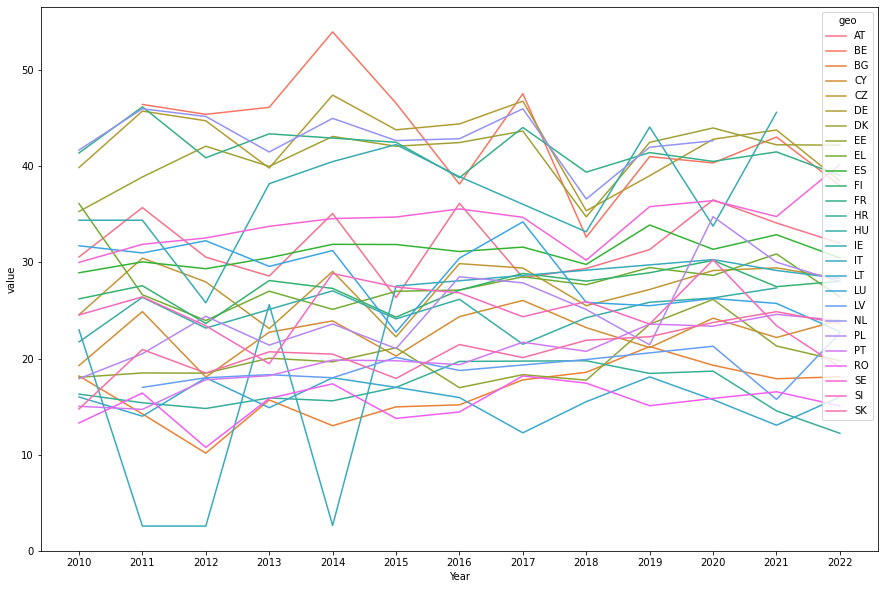

In [48]:
plt.subplots(figsize = (15, 10))

sns.lineplot(data = potato_yields_post_2010, x = 'Year', y = 'value', hue = 'geo')

In [49]:
potato_yields_clean = potato_yields_post_2010.fillna(method = 'ffill')

In [50]:
null_share(potato_yields_clean)

crops       0.0
strucpro    0.0
geo         0.0
Year        0.0
value       0.0
dtype: float64

C:\Users\justi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Potato Yields')

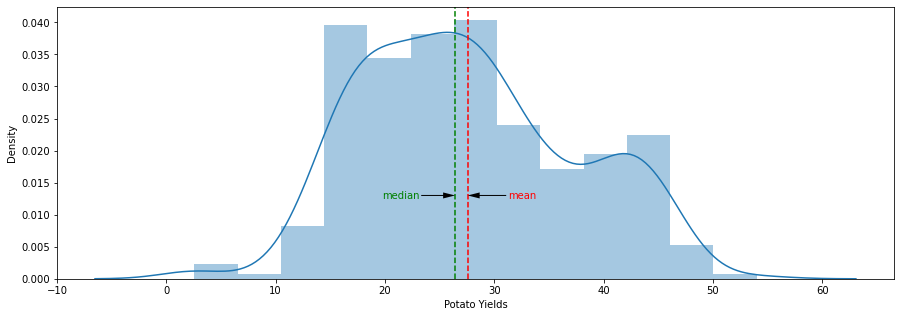

In [51]:
plt.subplots(figsize = (15, 5))

sns.distplot(potato_yields_clean.value, kde = True)

mean_val = potato_yields_clean.value.mean()
median_val = potato_yields_clean.value.median()

plt.axvline(mean_val, linestyle = 'dashed', color = 'red')
plt.annotate('mean', xy = (mean_val, 0.013), xytext = (mean_val + 5, 0.013),
            arrowprops = dict(facecolor = 'black', edgecolor = 'none', width = 1, headwidth = 6),
            ha = 'center', va = 'center', color = 'red')

plt.axvline(median_val, linestyle = 'dashed', color = 'green')
plt.annotate('median', xy = (median_val, 0.013), xytext = (median_val - 5, 0.013),
            arrowprops = dict(facecolor = 'black', edgecolor = 'none', width = 1, headwidth = 6),
            ha = 'center', va = 'center', color = 'green')

plt.xlabel('Potato Yields')

In [52]:
# I'll use the median seen as the data is slightly skewed

potato_yields_med = potato_yields_clean.groupby('geo').median().reset_index()

In [56]:
potato_yields_med.geo.replace(eu_codes, inplace = True)

In [57]:
fig = px.choropleth(potato_yields_med, locations = 'geo', color = 'value', color_continuous_scale = px.colors.sequential.Plasma)
fig.update_layout(geo_scope = 'europe', title_text = 'Potato Crop Yields Median: 2010-2022')
fig.show()

In [235]:
potato_yields_clean.rename(columns = {'value': 'Yields'}, inplace = True)

In [236]:
# I need to join all my datasets together, first of all I'll take a look at them to see how I can do this

In [237]:
potato_yields_clean.head()

crops  strucpro geo  Year  Yields
260  R1000  YI_HU_EU  AT  2010   30.57
261  R1000  YI_HU_EU  BE  2010   30.57
262  R1000  YI_HU_EU  BG  2010   18.19
263  R1000  YI_HU_EU  CY  2010   19.27
264  R1000  YI_HU_EU  CZ  2010   24.56

In [238]:
crop_rot_clean.head()

crop_rot geo       PC0    PC1-24   PC25-49   PC50-74    PC_GE75
0         AT  very low  very low  very low  very low       high
1         BE  very low  very low  very low  very low       high
2         BG  very low  very low  very low  very low  very high
3         CY      high  very low  very low  very low   very low
4         CZ  very low  very low  very low  very low  very high

In [239]:
nut_bal_clean.tail()

indic_ag geo  Year  BAL_UAA_N  INP_UAA_N  OUT_UAA_N  BAL_UAA_P  INP_UAA_P  \
805       SK  2015       38.4      129.3       90.9       -4.8       10.7   
806       SK  2016       16.4      126.4      110.0       -7.3       11.7   
807       SK  2017       27.1      107.4       80.3       -6.1        9.0   
808       SK  2018       62.6      136.4       73.8       -3.4       10.3   
809       SK  2019       63.3      135.8       72.6       -3.1       10.3   

indic_ag  OUT_UAA_P  
805            15.5  
806            19.1  
807            15.1  
808            13.7  
809            13.4

In [240]:
irrigation_clean.head()

geo irrigation
0  AT     medium
1  BE        low
2  BG       high
3  CY       high
4  CZ     medium

In [241]:
legal_form_clean.head()

leg_form geo   HLD_GRP   PER_LEG    PER_NTL  UNIT_CML
0         AT  very low  very low  very high  very low
1         BE  very low       low       high  very low
2         BG  very low    medium     medium  very low
3         CY  very low       low       high  very low
4         CZ  very low      high        low  very low

In [242]:
precipitation_clean.head()

Year geo  Precipitation
0  1901  AT        1052.84
1  1902  AT        1061.55
2  1903  AT        1201.34
3  1904  AT        1146.14
4  1905  AT        1127.85

In [243]:
soil_erosion_clean.head()

geo soil_erosion
0  AT          low
1  BE     very low
2  BG          low
3  CY          low
4  CZ     very low

In [244]:
temperature_clean.head()

Year geo  Temperature
0  1901  AT         5.41
1  1902  AT         5.34
2  1903  AT         5.88
3  1904  AT         6.22
4  1905  AT         5.79

In [245]:
tenure_status_clean.head()

tenure geo       CML       OWN  RENT   SHR_OTH
0       AT       low       low   low  very low
1       BE  very low       low  high  very low
2       BG      high  very low   low  very low
3       CY  very low       low  high  very low
4       CZ  very low       low  high  very low

In [246]:
training_clean.head()

training geo     BASIC       FULL       NAP     PRACT
0         AT       low        low  very low       low
1         BE       low        low  very low    medium
2         BG  very low        low  very low    medium
3         CY    medium   very low  very low    medium
4         CZ  very low  very high  very low  very low

In [247]:
# I'm going to join the datasets in two steps because most of them will only be joined by country but the climate data
# will also be joined by year

In [248]:
df_list = [irrigation_clean, crop_rot_clean, legal_form_clean,
           soil_erosion_clean, tenure_status_clean, training_clean]

df_merged = potato_yields_clean

for df in df_list:
    df_merged = pd.merge(df_merged, df, on = 'geo', how = 'left')

In [249]:
# There are fewer datasets to merge here and just to show you another way of doing it, I'll just chain together the merge calls

df_merged = df_merged.merge(precipitation_clean, on = ['geo', 'Year'], how = 'left') \
                     .merge(temperature_clean, on = ['geo', 'Year'], how = 'left') \
                     .merge(nut_bal_clean, on = ['geo', 'Year'], how = 'left')

In [250]:
df_merged.head()

crops  strucpro geo  Year  Yields irrigation       PC0    PC1-24   PC25-49  \
0  R1000  YI_HU_EU  AT  2010   30.57     medium  very low  very low  very low   
1  R1000  YI_HU_EU  BE  2010   30.57        low  very low  very low  very low   
2  R1000  YI_HU_EU  BG  2010   18.19       high  very low  very low  very low   
3  R1000  YI_HU_EU  CY  2010   19.27       high      high  very low  very low   
4  R1000  YI_HU_EU  CZ  2010   24.56     medium  very low  very low  very low   

    PC50-74  ...       NAP     PRACT Precipitation Temperature BAL_UAA_N  \
0  very low  ...  very low       low       1158.11        6.53      32.1   
1  very low  ...  very low    medium        910.47        9.36     142.0   
2  very low  ...  very low    medium        787.21       11.79      14.2   
3  very low  ...  very low    medium        418.97       20.35     191.4   
4  very low  ...  very low  very low        860.45        7.43      67.1   

  INP_UAA_N OUT_UAA_N BAL_UAA_P INP_UAA_P OUT_UAA_P  
0     105.3      73.2       0.9      14.0      13.1  
1     313.7     171.8       5.0      32.0      27.0  
2      70.3      56.1      -5.0       6.0      12.0  
3     240.9      49.5      31.0      43.0      12.0  
4     145.2      78.1      -2.1      11.1      13.1  

[5 rows x 32 columns]

In [251]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 0 to 337
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   crops          338 non-null    object 
 1   strucpro       338 non-null    object 
 2   geo            338 non-null    object 
 3   Year           338 non-null    object 
 4   Yields         338 non-null    float64
 5   irrigation     338 non-null    object 
 6   PC0            273 non-null    object 
 7   PC1-24         273 non-null    object 
 8   PC25-49        273 non-null    object 
 9   PC50-74        273 non-null    object 
 10  PC_GE75        273 non-null    object 
 11  HLD_GRP        325 non-null    object 
 12  PER_LEG        325 non-null    object 
 13  PER_NTL        325 non-null    object 
 14  UNIT_CML       325 non-null    object 
 15  soil_erosion   338 non-null    object 
 16  CML            338 non-null    object 
 17  OWN            338 non-null    object 
 18  RENT      

In [252]:
df_merged.describe()

Yields  Precipitation  Temperature   BAL_UAA_N   INP_UAA_N  \
count  338.000000     300.000000   300.000000  260.000000  260.000000   
mean    27.567515     802.960567    10.258300   60.026308  150.554538   
std      9.702126     249.215219     3.546169   41.857338   68.902592   
min      2.560000     340.570000     0.910000  -27.400000   64.400000   
25%     19.787500     642.472500     8.497500   35.275000  104.325000   
50%     26.420000     735.975000    10.130000   48.350000  133.250000   
75%     34.357500     886.422500    11.955000   69.050000  188.900000   
max     54.000000    1780.040000    20.350000  198.700000  402.200000   

        OUT_UAA_N   BAL_UAA_P   INP_UAA_P   OUT_UAA_P  
count  260.000000  260.000000  260.000000  260.000000  
mean    91.491308    2.701615   17.405385   14.574923  
std     40.066442    7.291955    7.461538    6.706977  
min     23.700000   -9.000000    5.000000    1.700000  
25%     63.825000   -1.325000   12.000000   10.300000  
50%     81.750000    1.600000   16.900000   14.300000  
75%    117.075000    4.225000   20.025000   17.825000  
max    220.200000   32.000000   43.000000   34.400000

In [253]:
# I have some missing values because the gross nutrient balance and the temperature data isn't available to 2022
# I'll forward fill the data because the temperature data has increased over time so the mean is not appropriate
# Also from the graph of the nutrient balance it exhibits some auto correlation so again ffill would be more
# appropriate than using say the mean

null_share(df_merged)

crops             0.000000
strucpro          0.000000
geo               0.000000
Year              0.000000
Yields            0.000000
irrigation        0.000000
PC0              19.230769
PC1-24           19.230769
PC25-49          19.230769
PC50-74          19.230769
PC_GE75          19.230769
HLD_GRP           3.846154
PER_LEG           3.846154
PER_NTL           3.846154
UNIT_CML          3.846154
soil_erosion      0.000000
CML               0.000000
OWN               0.000000
RENT              0.000000
SHR_OTH           0.000000
BASIC             0.000000
FULL              0.000000
NAP               0.000000
PRACT             0.000000
Precipitation    11.242604
Temperature      11.242604
BAL_UAA_N        23.076923
INP_UAA_N        23.076923
OUT_UAA_N        23.076923
BAL_UAA_P        23.076923
INP_UAA_P        23.076923
OUT_UAA_P        23.076923
dtype: float64

In [254]:
grouped_null_counts(df_merged, 'geo')

crops  strucpro  geo  Year  Yields  irrigation    PC0  PC1-24  PC25-49  \
geo                                                                           
AT     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
BE     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
BG     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
CY     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
CZ     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
DE     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
DK     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
EE     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
EL     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
ES     0.0       0.0  0.0   0.0     0.0         0.0  100.0   100.0    100.0   
FI     0.0       0.0  0.0   0.0     0.0         0.0  100.0   100.0    100.0   
FR     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
HR     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
HU     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
IE     0.0       0.0  0.0   0.0     0.0         0.0  100.0   100.0    100.0   
IT     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
LT     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
LU     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
LV     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
NL     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
PL     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
PT     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
RO     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   
SE     0.0       0.0  0.0   0.0     0.0         0.0  100.0   100.0    100.0   
SI     0.0       0.0  0.0   0.0     0.0         0.0  100.0   100.0    100.0   
SK     0.0       0.0  0.0   0.0     0.0         0.0    0.0     0.0      0.0   

     PC50-74  ...  NAP  PRACT  Precipitation  Temperature  BAL_UAA_N  \
geo           ...                                                      
AT       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
BE       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
BG       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
CY       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
CZ       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
DE       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
DK       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
EE       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
EL       0.0  ...  0.0    0.0     100.000000   100.000000  23.076923   
ES     100.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
FI     100.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
FR       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
HR       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
HU       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
IE     100.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
IT       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
LT       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
LU       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
LV       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
NL       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
PL       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
PT       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
RO       0.0  ...  0.0    0.0       7.692308     7.692308  23.07

In [255]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 0 to 337
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   crops          338 non-null    object 
 1   strucpro       338 non-null    object 
 2   geo            338 non-null    object 
 3   Year           338 non-null    object 
 4   Yields         338 non-null    float64
 5   irrigation     338 non-null    object 
 6   PC0            273 non-null    object 
 7   PC1-24         273 non-null    object 
 8   PC25-49        273 non-null    object 
 9   PC50-74        273 non-null    object 
 10  PC_GE75        273 non-null    object 
 11  HLD_GRP        325 non-null    object 
 12  PER_LEG        325 non-null    object 
 13  PER_NTL        325 non-null    object 
 14  UNIT_CML       325 non-null    object 
 15  soil_erosion   338 non-null    object 
 16  CML            338 non-null    object 
 17  OWN            338 non-null    object 
 18  RENT      

In [256]:
# Some countries have no crop rotation data, I'll give them a label of Other

crop_rotation_cols = df_merged.columns[df_merged.columns.str.startswith('PC')].to_list()

for col in crop_rotation_cols:
    df_merged[col] = df_merged[col].fillna('Other')

In [257]:
# Greece has no temperature or precipitation data
# I'll replace the Greek data with the mean of the italian data
# I've chosen italy because it's a mediterranean climate quite close to Greece

grouped_null_counts(df_merged, 'geo')

crops  strucpro  geo  Year  Yields  irrigation  PC0  PC1-24  PC25-49  \
geo                                                                         
AT     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
BE     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
BG     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
CY     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
CZ     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
DE     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
DK     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
EE     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
EL     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
ES     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
FI     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
FR     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
HR     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
HU     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
IE     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
IT     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
LT     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
LU     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
LV     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
NL     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
PL     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
PT     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
RO     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
SE     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
SI     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   
SK     0.0       0.0  0.0   0.0     0.0         0.0  0.0     0.0      0.0   

     PC50-74  ...  NAP  PRACT  Precipitation  Temperature  BAL_UAA_N  \
geo           ...                                                      
AT       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
BE       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
BG       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
CY       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
CZ       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
DE       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
DK       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
EE       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
EL       0.0  ...  0.0    0.0     100.000000   100.000000  23.076923   
ES       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
FI       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
FR       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
HR       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
HU       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
IE       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
IT       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
LT       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
LU       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
LV       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
NL       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
PL       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
PT       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
RO       0.0  ...  0.0    0.0       7.692308     7.692308  23.076923   
SE       0.0  ...  0.0    0.0       7.692308    

In [258]:
# Calculating Italian means for temps and prec

italy_mean_temp = df_merged[df_merged.geo == 'IT'].Temperature.mean()
italy_mean_prec = df_merged[df_merged.geo == 'IT'].Precipitation.mean()

In [259]:
# Replacing Greek values

df_merged.loc[df_merged['geo'] == 'EL', 'Temperature'] = df_merged['Temperature'].fillna(italy_mean_temp)
df_merged.loc[df_merged['geo'] == 'EL', 'Precipitation'] = df_merged['Precipitation'].fillna(italy_mean_prec)

In [260]:
# Germany has no data on legal form, I'll replace the missing values with the mode of the data

grouped_null_counts(df_merged, 'geo')[['HLD_GRP', 'PER_LEG', 'PER_NTL', 'UNIT_CML']]

legal_form_cols = ['HLD_GRP', 'PER_LEG', 'PER_NTL', 'UNIT_CML']

for col in legal_form_cols:
    df_merged[col] = df_merged[col].fillna(df_merged[col].mode()[0])

In [261]:
cols_to_be_filled = df_merged.select_dtypes(include = 'float').columns.to_list()
cols_to_be_filled.remove('Yields')

df_merged = df_merged.groupby('geo').apply(lambda x: x.fillna(method = 'ffill'))


In [268]:
df_merged.head()

crops  strucpro geo  Year  Yields irrigation       PC0    PC1-24   PC25-49  \
0  R1000  YI_HU_EU  AT  2010   30.57     medium  very low  very low  very low   
1  R1000  YI_HU_EU  BE  2010   30.57        low  very low  very low  very low   
2  R1000  YI_HU_EU  BG  2010   18.19       high  very low  very low  very low   
3  R1000  YI_HU_EU  CY  2010   19.27       high      high  very low  very low   
4  R1000  YI_HU_EU  CZ  2010   24.56     medium  very low  very low  very low   

    PC50-74  ...       NAP     PRACT Precipitation Temperature BAL_UAA_N  \
0  very low  ...  very low       low       1158.11        6.53      32.1   
1  very low  ...  very low    medium        910.47        9.36     142.0   
2  very low  ...  very low    medium        787.21       11.79      14.2   
3  very low  ...  very low    medium        418.97       20.35     191.4   
4  very low  ...  very low  very low        860.45        7.43      67.1   

  INP_UAA_N OUT_UAA_N BAL_UAA_P INP_UAA_P OUT_UAA_P  
0     105.3      73.2       0.9      14.0      13.1  
1     313.7     171.8       5.0      32.0      27.0  
2      70.3      56.1      -5.0       6.0      12.0  
3     240.9      49.5      31.0      43.0      12.0  
4     145.2      78.1      -2.1      11.1      13.1  

[5 rows x 32 columns]

In [264]:
#df_merged.to_csv('df_merged.csv')

In [269]:
null_share(df_merged)

crops            0.0
strucpro         0.0
geo              0.0
Year             0.0
Yields           0.0
irrigation       0.0
PC0              0.0
PC1-24           0.0
PC25-49          0.0
PC50-74          0.0
PC_GE75          0.0
HLD_GRP          0.0
PER_LEG          0.0
PER_NTL          0.0
UNIT_CML         0.0
soil_erosion     0.0
CML              0.0
OWN              0.0
RENT             0.0
SHR_OTH          0.0
BASIC            0.0
FULL             0.0
NAP              0.0
PRACT            0.0
Precipitation    0.0
Temperature      0.0
BAL_UAA_N        0.0
INP_UAA_N        0.0
OUT_UAA_N        0.0
BAL_UAA_P        0.0
INP_UAA_P        0.0
OUT_UAA_P        0.0
dtype: float64

In [270]:
# First of all I'll create a list of the categorical variables which are to be one hot encoded

cat_exp_var = df_merged.select_dtypes(include = 'object').columns[4:]

df_merged_hot = pd.get_dummies(df_merged, columns = cat_exp_var)

In [271]:
df_merged_hot.head()

crops  strucpro geo  Year  Yields  Precipitation  Temperature  BAL_UAA_N  \
0  R1000  YI_HU_EU  AT  2010   30.57        1158.11         6.53       32.1   
1  R1000  YI_HU_EU  BE  2010   30.57         910.47         9.36      142.0   
2  R1000  YI_HU_EU  BG  2010   18.19         787.21        11.79       14.2   
3  R1000  YI_HU_EU  CY  2010   19.27         418.97        20.35      191.4   
4  R1000  YI_HU_EU  CZ  2010   24.56         860.45         7.43       67.1   

   INP_UAA_N  OUT_UAA_N  ...  FULL_low  FULL_medium  FULL_very high  \
0      105.3       73.2  ...         1            0               0   
1      313.7      171.8  ...         1            0               0   
2       70.3       56.1  ...         1            0               0   
3      240.9       49.5  ...         0            0               0   
4      145.2       78.1  ...         0            0               1   

   FULL_very low  NAP_low  NAP_very low  PRACT_high  PRACT_low  PRACT_medium  \
0              0        0             1           0          1             0   
1              0        0             1           0          0             1   
2              0        0             1           0          0             1   
3              1        0             1           0          0             1   
4              0        0             1           0          0             0   

   PRACT_very low  
0               0  
1               0  
2               0  
3               0  
4               1  

[5 rows x 82 columns]

In [513]:
df_merged_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 259
Data columns (total 75 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   crops                  260 non-null    object 
 1   strucpro               260 non-null    object 
 2   geo                    260 non-null    object 
 3   Year                   260 non-null    object 
 4   Yields                 260 non-null    float64
 5   Precipitation          260 non-null    float64
 6   Temperature            260 non-null    float64
 7   BAL_UAA_N              260 non-null    float64
 8   INP_UAA_N              260 non-null    float64
 9   OUT_UAA_N              260 non-null    float64
 10  BAL_UAA_P              260 non-null    float64
 11  INP_UAA_P              260 non-null    float64
 12  OUT_UAA_P              260 non-null    float64
 13  PC0_high               260 non-null    uint8  
 14  PC0_low                260 non-null    uint8  
 15  PC0_me

<AxesSubplot:>

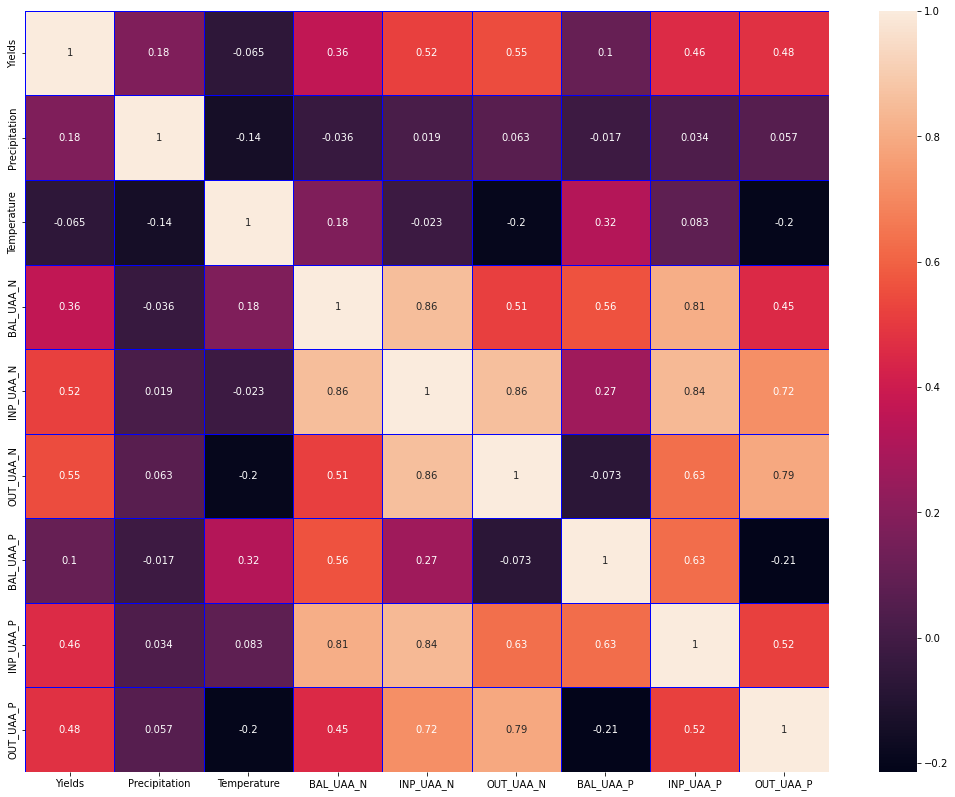

In [501]:
corr = df_merged.corr()

plt.figure(figsize = (18, 14))
sns.heatmap(corr, annot = True, linecolor = 'blue', lw = 0.5)

In [502]:
df_merged_hot.select_dtypes(include = ['int', 'float']).columns.size

9

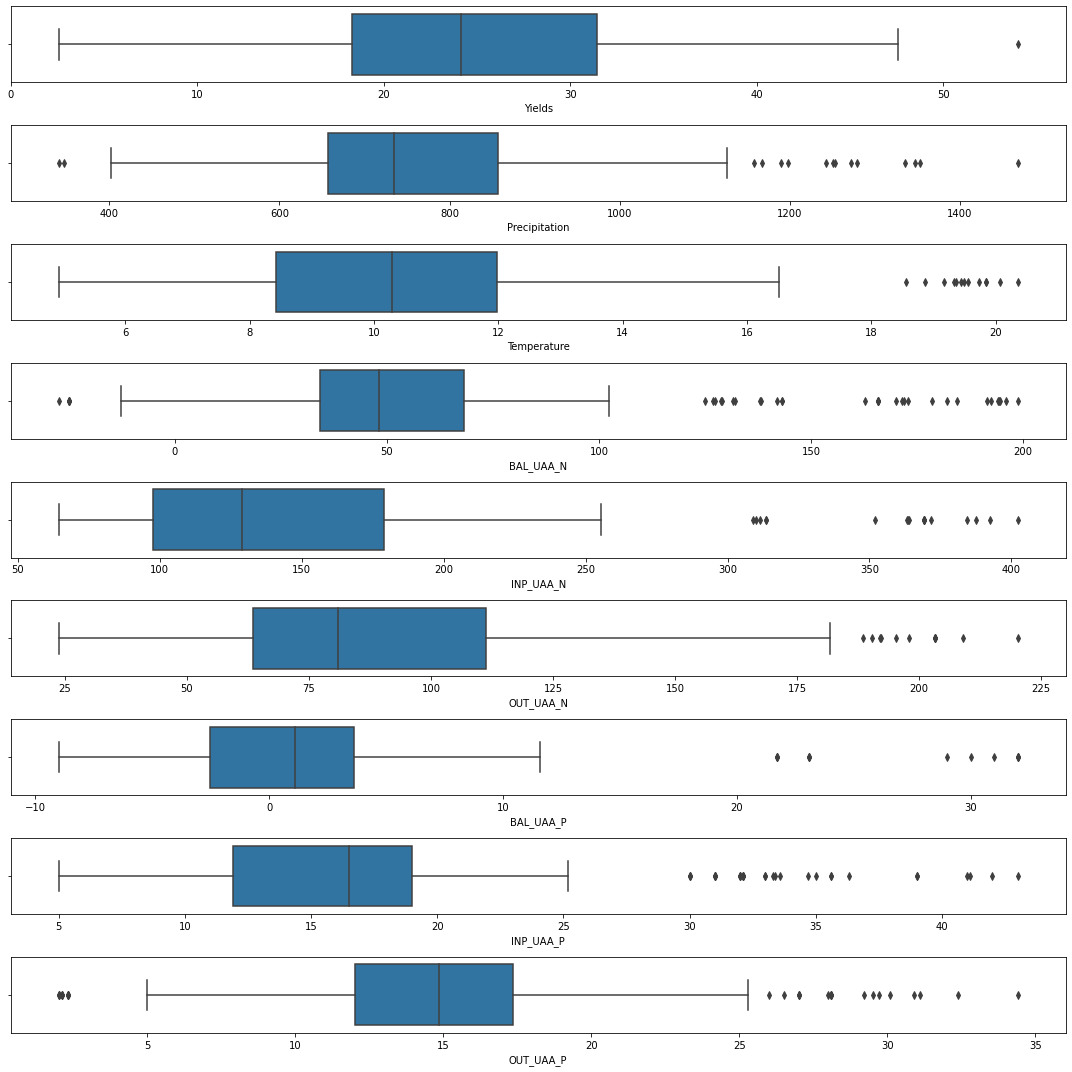

In [503]:
fig, ax = plt.subplots(df_merged_hot.select_dtypes(include = ['int', 'float']).columns.size, 1, figsize = (15, 15))

for i, col in enumerate(df_merged_hot.select_dtypes(include = ['int', 'float']).columns):
    
    sns.boxplot(x = df_merged_hot[col], ax = ax[i])
    #ax[i].set_title(f'Variable: {col}')
    
plt.tight_layout()

In [272]:
# Standardise the data to mean 0 and standard deviation 1
# This is only applicable to the numerical variables 

scaler = StandardScaler()

float_cols = df_merged_hot.select_dtypes(include = ['float'])

scaled_float_cols = scaler.fit_transform(float_cols)

df_merged_hot[float_cols.columns] = scaled_float_cols

In [275]:
df_merged_hot.head()

#df_merged_hot.to_csv('df_merged_hot.csv')

In [516]:
# Ready to run models, I'll just drop variables that won't be included
# I want a copy of the full dataset though so I can add a lag later for which I need to retain the geo information
# I'm using pandas copy method so I have an indpendent copy

#df_merged_hot_copy = df_merged_hot.copy()

#df_merged_hot.drop(columns = ['crops', 'strucpro', 'geo', 'Year'], inplace = True)

# I'll write this out as a csv as well so I can start using the data without running everything above

#df_merged_hot.to_csv('df_merged_hot.csv')

In [158]:
df_merged_hot_full = pd.read_csv('df_merged_hot.csv')

df_merged_hot_full.drop(columns = 'Unnamed: 0', inplace = True)

df_merged_hot = df_merged_hot_full.drop(columns = ['crops', 'strucpro', 'geo', 'Year'])

In [24]:
df_merged_hot.head()

Yields  Precipitation  Temperature  BAL_UAA_N  INP_UAA_N  OUT_UAA_N  \
0  0.309926       1.480500    -1.083556  -0.627066  -0.645110  -0.480792   
1  0.309926       0.451423    -0.283956   2.136568   2.503788   2.081560   
2 -0.967975      -0.060788     0.402627  -1.077194  -1.173956  -0.925176   
3 -0.856494      -1.591023     2.821207   3.378821   1.403789  -1.096692   
4 -0.310445       0.243563    -0.829266   0.253072  -0.042226  -0.353454   

   BAL_UAA_P  INP_UAA_P  OUT_UAA_P  irrigation_high  ...  FULL_low  \
0  -0.148814  -0.425947  -0.293361                0  ...         1   
1   0.458771   2.162410   1.902453                0  ...         1   
2  -1.023143  -1.576328  -0.467131                1  ...         1   
3   4.311748   3.744183  -0.467131                1  ...         0   
4  -0.593388  -0.842960  -0.293361                0  ...         0   

   FULL_medium  FULL_very high  FULL_very low  NAP_low  NAP_very low  \
0            0               0              0        0             1   
1            0               0              0        0             1   
2            0               0              0        0             1   
3            0               0              1        0             1   
4            0               1              0        0             1   

   PRACT_high  PRACT_low  PRACT_medium  PRACT_very low  
0           0          1             0               0  
1           0          0             1               0  
2           0          0             1               0  
3           0          0             1               0  
4           0          0             0               1  

[5 rows x 78 columns]

In [242]:
y = df_merged_hot['Yields']
X = df_merged_hot.drop(columns = 'Yields')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((270, 77), (68, 77), (270,), (68,))

In [243]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

LinearRegression()

In [244]:
# Predict on the the training and testing data

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

In [245]:
def model_summary(model, x_train, y_train, x_test, y_test):
    
    y_test_pred = model.predict(x_test)
    
    print('R-Squared of the model in training set is: {}'.format(model.score(x_train, y_train)))
    print('-----Test set statistics------')
    print('R-squared of the model in test set is: {}'.format(model.score(x_test, y_test)))
    print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_test_pred)))
    print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100))

In [246]:
def actual_vs_predicted_scat(model, x_train, y_train, x_test, y_test, title):
    
    y_preds_train = model.predict(x_train)
    y_preds_test = model.predict(x_test)
    
    fig, ax = plt.subplots(figsize = (15, 6))

    ax.scatter(x = y_train, y = y_preds_train, label = 'Training Set')
    ax.scatter(x = y_test, y = y_preds_test, label = 'Testing Set')

    ax.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], ls = '--')

    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')

    ax.legend()

    ax.set(title = title)

    plt.show()

In [247]:
def model_dict(model, x_train, y_train, x_test, y_test, grid_search = True, group = 'Baseline'):
    
    model_name = model.__class__.__name__
    if grid_search:
        model_name = model.estimator.__class__.__name__
    model.fit(x_train, y_train)
    
    y_preds_train = model.predict(x_train)
    y_preds_test = model.predict(x_test)
    
    dict = {'Model': model_name,
            'Group': group,
            'Train_R_Squared': round(model.score(x_train, y_train), ndigits = 2),
            'Test_R_Squared': round(model.score(x_test, y_test), ndigits = 2),
            'Train_RMSE': round(rmse(y_train, y_preds_train), ndigits = 2),
            'Test_RMSE': round(rmse(y_test, y_preds_test), ndigits = 2)}
    
    return dict


In [248]:
model_summary(lrm, X_train, y_train, X_test, y_test)

R-Squared of the model in training set is: 0.7494974564011059
-----Test set statistics------
R-squared of the model in test set is: 0.6880600689939937
Root mean squared error of the prediction is: 0.5528811120612733
Mean absolute percentage error of the prediction is: 103.97231112451317


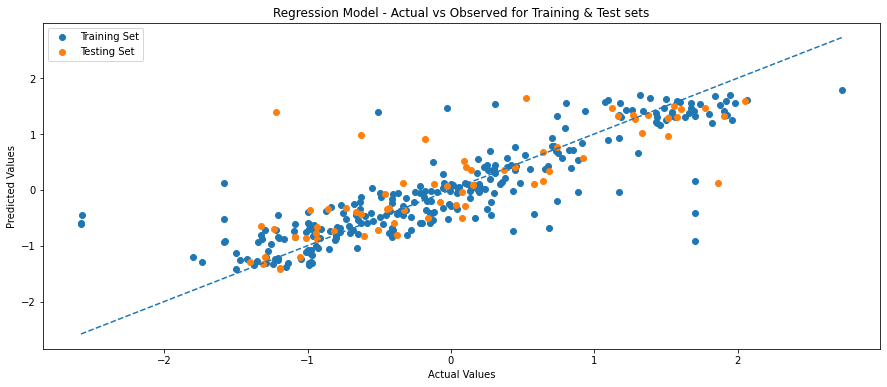

In [249]:
actual_vs_predicted_scat(lrm, X_train, y_train, X_test, y_test, 
                         title = 'Regression Model - Actual vs Observed for Training & Test sets')

In [250]:
lrm_dict = model_dict(lrm, X_train, y_train, X_test, y_test, grid_search = False)
lrm_dict

{'Model': 'LinearRegression',
 'Group': 'Baseline',
 'Train_R_Squared': 0.75,
 'Test_R_Squared': 0.69,
 'Train_RMSE': 0.5,
 'Test_RMSE': 0.55}

In [ ]:
# Let's try ridge regression

In [251]:
def grid_search_model(model, param_grid, x_train, y_train, x_test, y_test, cv = 5, graph = False, title = '', group = 'Baseline'):
    
    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv)
    grid_search.fit(x_train, y_train)
    
    y_preds_train = grid_search.predict(x_train)
    y_preds_test = grid_search.predict(x_test)
    
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best score: {grid_search.best_score_}')
    
    summary = model_summary(grid_search, x_train, y_train, x_test, y_test)
    model_dict_check = model_dict(grid_search, x_train, y_train, x_test, y_test, grid_search = True, group = group)
    
    
    
    if graph == True:
        graph = actual_vs_predicted_scat(grid_search, x_train, y_train, x_test, y_test, 
                                         title = f'{title} Regression Model - Actual vs Observed for Training & Test sets')
        
    return model_dict_check
        
    

Best parameters: {'alpha': 1, 'fit_intercept': False}
Best score: 0.6438890718395788
R-Squared of the model in training set is: 0.7478653486036957
-----Test set statistics------
R-squared of the model in test set is: 0.6958475380341123
Root mean squared error of the prediction is: 0.5459362543263375
Mean absolute percentage error of the prediction is: 99.15660276839749


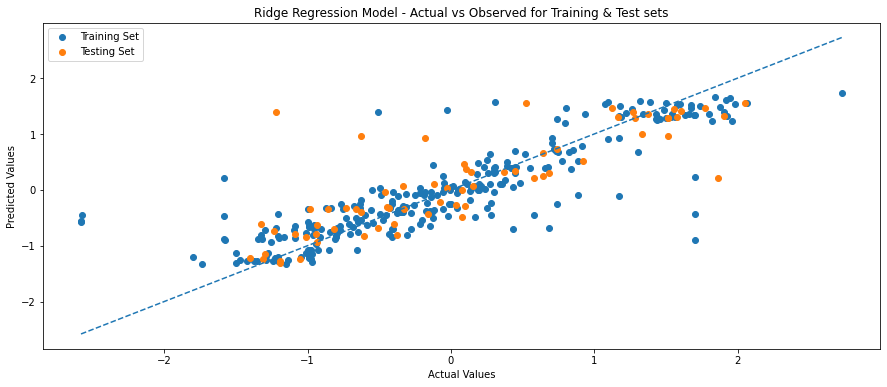

In [252]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'fit_intercept': [True, False]}

ridge = Ridge()

ridge_model = grid_search_model(ridge, param_grid, X_train, y_train, X_test, y_test, graph = True, title = 'Ridge');

In [253]:
ridge_model

{'Model': 'Ridge',
 'Group': 'Baseline',
 'Train_R_Squared': 0.75,
 'Test_R_Squared': 0.7,
 'Train_RMSE': 0.5,
 'Test_RMSE': 0.55}

C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.528e-02, tolerance: 2.111e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.214e-02, tolerance: 2.178e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e-01, toleranc

Best parameters: {'alpha': 0.001, 'fit_intercept': False}
Best score: 0.6405472173462917
R-Squared of the model in training set is: 0.7477285559704157
-----Test set statistics------
R-squared of the model in test set is: 0.6988498459589085
Root mean squared error of the prediction is: 0.5432350865352411
Mean absolute percentage error of the prediction is: 98.34126220186215


C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.528e-02, tolerance: 2.111e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.214e-02, tolerance: 2.178e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e-01, toleranc

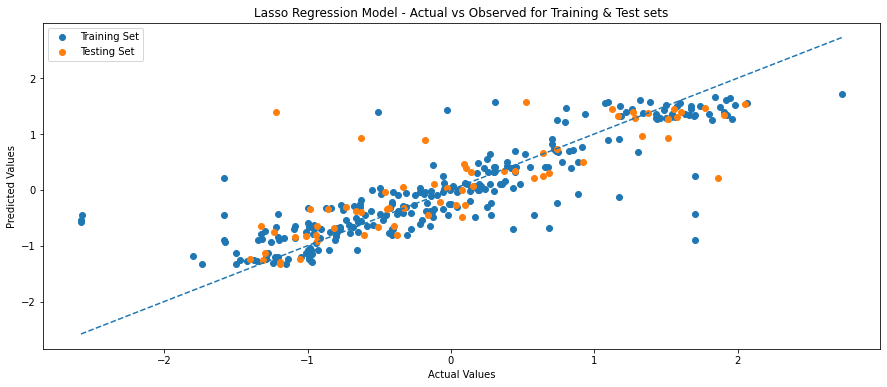

In [254]:
# Let's try lasso regression

lasso = Lasso()

lasso_model = grid_search_model(lasso, param_grid, X_train, y_train, X_test, y_test, graph = True, title = 'Lasso')


In [255]:
lasso_model

{'Model': 'Lasso',
 'Group': 'Baseline',
 'Train_R_Squared': 0.75,
 'Test_R_Squared': 0.7,
 'Train_RMSE': 0.5,
 'Test_RMSE': 0.54}

Best parameters: {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best score: 0.561527506745132
R-Squared of the model in training set is: 0.7517396815244386
-----Test set statistics------
R-squared of the model in test set is: 0.5312259036167879
Root mean squared error of the prediction is: 0.6777633337554523
Mean absolute percentage error of the prediction is: 91.4531420745269


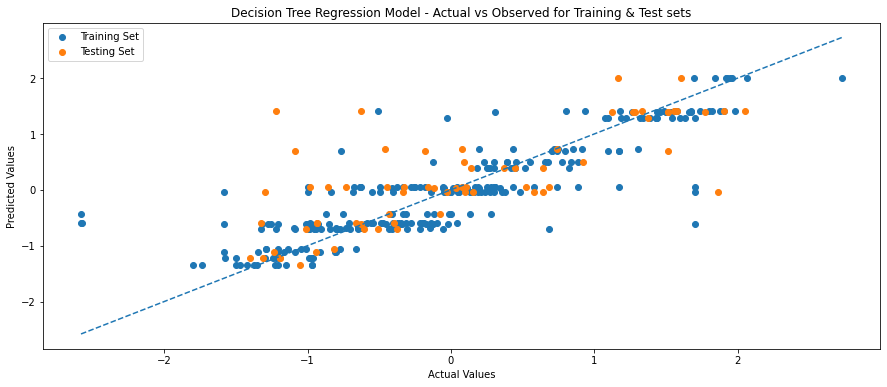

In [256]:
# Let's run a decision tree regression


param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 4, 6, 8]}


dt_model = grid_search_model(DecisionTreeRegressor(), param_grid, X_train, y_train, X_test, y_test, 
                             graph = True, title = 'Decision Tree')

In [257]:
dt_model

{'Model': 'DecisionTreeRegressor',
 'Group': 'Baseline',
 'Train_R_Squared': 0.75,
 'Test_R_Squared': 0.53,
 'Train_RMSE': 0.5,
 'Test_RMSE': 0.68}

In [258]:
# Let's fit a Random Forest Regressor

ran_for_reg = RandomForestRegressor()

param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 5, 10]}

ran_for_model = grid_search_model(RandomForestRegressor(), param_grid, X_train, y_train, X_test, y_test, 
                             graph = False, title = 'Random Forest')

Best parameters: {'max_depth': 10, 'n_estimators': 100}
Best score: 0.6259457200989791
R-Squared of the model in training set is: 0.937877324553968
-----Test set statistics------
R-squared of the model in test set is: 0.6681652557292985
Root mean squared error of the prediction is: 0.570239366748333
Mean absolute percentage error of the prediction is: 76.84893614598344


In [259]:
ran_for_model

{'Model': 'RandomForestRegressor',
 'Group': 'Baseline',
 'Train_R_Squared': 0.94,
 'Test_R_Squared': 0.66,
 'Train_RMSE': 0.25,
 'Test_RMSE': 0.58}

In [3]:
# I want to see if including a lag of the dependent variable improves model performance

In [260]:
df_merged_hot_full.head()

df_merged_hot_copy = df_merged_hot_full.copy()

In [261]:
df_merged_hot_copy.head()

crops  strucpro geo  Year    Yields  Precipitation  Temperature  BAL_UAA_N  \
0  R1000  YI_HU_EU  AT  2010  0.309926       1.480500    -1.083556  -0.627066   
1  R1000  YI_HU_EU  BE  2010  0.309926       0.451423    -0.283956   2.136568   
2  R1000  YI_HU_EU  BG  2010 -0.967975      -0.060788     0.402627  -1.077194   
3  R1000  YI_HU_EU  CY  2010 -0.856494      -1.591023     2.821207   3.378821   
4  R1000  YI_HU_EU  CZ  2010 -0.310445       0.243563    -0.829266   0.253072   

   INP_UAA_N  OUT_UAA_N  ...  FULL_low  FULL_medium  FULL_very high  \
0  -0.645110  -0.480792  ...         1            0               0   
1   2.503788   2.081560  ...         1            0               0   
2  -1.173956  -0.925176  ...         1            0               0   
3   1.403789  -1.096692  ...         0            0               0   
4  -0.042226  -0.353454  ...         0            0               1   

   FULL_very low  NAP_low  NAP_very low  PRACT_high  PRACT_low  PRACT_medium  \
0              0        0             1           0          1             0   
1              0        0             1           0          0             1   
2              0        0             1           0          0             1   
3              1        0             1           0          0             1   
4              0        0             1           0          0             0   

   PRACT_very low  
0               0  
1               0  
2               0  
3               0  
4               1  

[5 rows x 82 columns]

In [262]:
df_merged_hot_copy['Yields_lag'] = df_merged_hot_copy.groupby('geo').Yields.shift(periods = 1)

In [263]:
df_merged_hot_copy.dropna(inplace = True)

df_merged_hot_copy.drop(columns = ['crops', 'strucpro', 'geo', 'Year'], inplace = True)

In [264]:
df_merged_hot_copy.head()

Yields  Precipitation  Temperature  BAL_UAA_N  INP_UAA_N  OUT_UAA_N  \
26  0.840492       0.604014    -0.693645  -0.541567  -0.379177  -0.114370   
27  1.949107      -0.027835     0.233101   2.166744   2.503788   2.047777   
28 -1.375706      -1.118330     0.145512  -1.135032  -1.216264  -0.935571   
29 -0.276381      -1.188684     2.315453   3.562392   1.446097  -1.213635   
30  0.297539      -0.877392    -0.411101   0.564893   0.330988  -0.031211   

    BAL_UAA_P  INP_UAA_P  OUT_UAA_P  irrigation_high  ...  FULL_medium  \
26  -0.267367  -0.109592   0.164759                0  ...            0   
27   0.458771   2.162410   1.902453                0  ...            0   
28  -1.171335  -1.720126  -0.467131                1  ...            0   
29   4.459939   3.600386  -0.625103                1  ...            0   
30  -0.771218  -0.713542   0.054178                0  ...            0   

    FULL_very high  FULL_very low  NAP_low  NAP_very low  PRACT_high  \
26               0              0        0             1           0   
27               0              0        0             1           0   
28               0              0        0             1           0   
29               0              1        0             1           0   
30               1              0        0             1           0   

    PRACT_low  PRACT_medium  PRACT_very low  Yields_lag  
26          1             0               0    0.309926  
27          0             1               0    0.309926  
28          0             1               0   -0.967975  
29          0             1               0   -0.856494  
30          0             0               1   -0.310445  

[5 rows x 79 columns]

In [265]:
y = df_merged_hot_copy['Yields']
X = df_merged_hot_copy.drop(columns = 'Yields')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((249, 78), (63, 78), (249,), (63,))

In [266]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

LinearRegression()

In [267]:
# Predict on the the training and testing data

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

In [268]:
# Including the lag significantly improved performance

model_summary(lrm, X_train, y_train, X_test, y_test)

R-Squared of the model in training set is: 0.7308233826596708
-----Test set statistics------
R-squared of the model in test set is: 0.7862862595873201
Root mean squared error of the prediction is: 0.47717840735862005
Mean absolute percentage error of the prediction is: 63.830216662267084


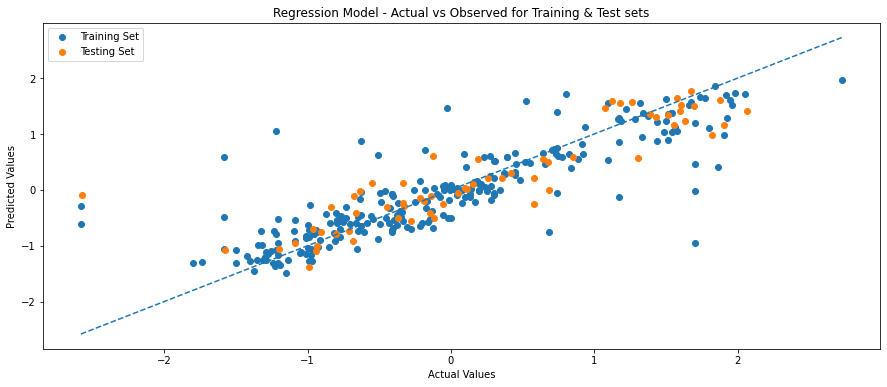

In [269]:
actual_vs_predicted_scat(lrm, X_train, y_train, X_test, y_test, 
                         title = 'Regression Model - Actual vs Observed for Training & Test sets')

In [270]:
lrm_lag = model_dict(lrm, X_train, y_train, X_test, y_test, grid_search = False, group = 'Lag')
lrm_lag

{'Model': 'LinearRegression',
 'Group': 'Lag',
 'Train_R_Squared': 0.73,
 'Test_R_Squared': 0.79,
 'Train_RMSE': 0.52,
 'Test_RMSE': 0.48}

In [271]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'fit_intercept': [True, False]}

ridge = Ridge()

ridge_model_lag = grid_search_model(ridge, param_grid, X_train, y_train, X_test, y_test, graph = False, title = 'Ridge',
                                   group = 'Lag')

Best parameters: {'alpha': 10, 'fit_intercept': False}
Best score: 0.5737007965632576
R-Squared of the model in training set is: 0.708077085718976
-----Test set statistics------
R-squared of the model in test set is: 0.7828847039723195
Root mean squared error of the prediction is: 0.4809608995502211
Mean absolute percentage error of the prediction is: 68.24321334124895


In [272]:
ridge_model_lag

{'Model': 'Ridge',
 'Group': 'Lag',
 'Train_R_Squared': 0.71,
 'Test_R_Squared': 0.78,
 'Train_RMSE': 0.54,
 'Test_RMSE': 0.48}

In [273]:
lasso = Lasso()

lasso_model_lag = grid_search_model(lasso, param_grid, X_train, y_train, X_test, y_test, graph = False, title = 'Lasso',
                                   group = 'Lag')

C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.685e-02, tolerance: 1.812e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e-02, tolerance: 1.908e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e-01, toleranc

Best parameters: {'alpha': 0.001, 'fit_intercept': True}
Best score: 0.5590295507768828
R-Squared of the model in training set is: 0.7268325825608793
-----Test set statistics------
R-squared of the model in test set is: 0.7991231442555512
Root mean squared error of the prediction is: 0.4626254404507821
Mean absolute percentage error of the prediction is: 61.7408708474298


C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.685e-02, tolerance: 1.812e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e-02, tolerance: 1.908e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e-01, toleranc

In [274]:
lasso_model_lag

{'Model': 'Lasso',
 'Group': 'Lag',
 'Train_R_Squared': 0.73,
 'Test_R_Squared': 0.8,
 'Train_RMSE': 0.52,
 'Test_RMSE': 0.46}

In [275]:
# Let's run a decision tree regression

param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 4, 6, 8]}


dt_model_lag = grid_search_model(DecisionTreeRegressor(), param_grid, X_train, y_train, X_test, y_test, 
                             graph = False, title = 'Decision Tree', group = 'Lag')

Best parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.45105687075011563
R-Squared of the model in training set is: 0.6037592131786361
-----Test set statistics------
R-squared of the model in test set is: 0.5944853814433738
Root mean squared error of the prediction is: 0.6573063351834286
Mean absolute percentage error of the prediction is: 116.3145915300144


In [276]:
dt_model_lag

{'Model': 'DecisionTreeRegressor',
 'Group': 'Lag',
 'Train_R_Squared': 0.6,
 'Test_R_Squared': 0.59,
 'Train_RMSE': 0.63,
 'Test_RMSE': 0.66}

In [ ]:
# As the random forest regressor was the best model without the lag, let's try it again with the lag

In [277]:
# This again improved performance

ran_for_reg = RandomForestRegressor()

param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 5, 10]}

ran_for_model_lag = grid_search_model(RandomForestRegressor(), param_grid, X_train, y_train, X_test, y_test, 
                             graph = False, title = 'Random Forest', group = 'Lag')

Best parameters: {'max_depth': 5, 'n_estimators': 50}
Best score: 0.5306658317128468
R-Squared of the model in training set is: 0.8576029941512889
-----Test set statistics------
R-squared of the model in test set is: 0.7694371002257299
Root mean squared error of the prediction is: 0.49563192584153787
Mean absolute percentage error of the prediction is: 64.81017561402282


In [278]:
ran_for_model_lag

{'Model': 'RandomForestRegressor',
 'Group': 'Lag',
 'Train_R_Squared': 0.94,
 'Test_R_Squared': 0.79,
 'Train_RMSE': 0.25,
 'Test_RMSE': 0.48}

In [545]:
# Let's try some feature selection, I'll again use simple linear regression as the base line

In [279]:
def feature_selection(model, x_train, y_train, x_test, step = 1, cv = 5):
    
    selector = RFECV(model, step = step, cv = cv)
    selector = selector.fit(x_train.values, y_train.values)
    
    x_train_selected = x_train.loc[:, selector.support_]
    x_test_selected = x_test.loc[:, selector.support_]
    
    feature_dict = {'x_train': x_train_selected,
                    'x_test': x_test_selected}
    
    return feature_dict

In [280]:
selector_lrm = feature_selection(LinearRegression(), X_train, y_train, X_test)

In [281]:
lrm_feat = LinearRegression()
lrm_feat.fit(selector_lrm['x_train'], y_train)

LinearRegression()

In [282]:
lrm_feat_dict = model_dict(lrm_feat, selector_lrm['x_train'], y_train, selector_lrm['x_test'], 
                           y_test, grid_search = False, group = 'Feature Engineering')

In [283]:
lrm_feat_dict

{'Model': 'LinearRegression',
 'Group': 'Feature Engineering',
 'Train_R_Squared': 0.71,
 'Test_R_Squared': 0.8,
 'Train_RMSE': 0.53,
 'Test_RMSE': 0.47}

In [284]:
# The feature engineering massively improved performance
# Although the better R-squared in the test set is suspicious
# I'll try again regularization

model_summary(lrm_feat, selector_lrm['x_train'], y_train, selector_lrm['x_test'], y_test)

R-Squared of the model in training set is: 0.7140629013566967
-----Test set statistics------
R-squared of the model in test set is: 0.796799404111012
Root mean squared error of the prediction is: 0.46529356814505163
Mean absolute percentage error of the prediction is: 59.93047938946766


In [560]:
# Let's try with ridge regression

In [285]:
selector_ridge = feature_selection(Ridge(), X_train, y_train, X_test)

In [286]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'fit_intercept': [True, False]}

ridge_model_feat = grid_search_model(Ridge(), param_grid, selector_ridge['x_train'], y_train, selector_ridge['x_test'], 
                                     y_test, graph = False, title = 'Ridge', group = 'Feature Engineering')

Best parameters: {'alpha': 1, 'fit_intercept': True}
Best score: 0.6186798853447533
R-Squared of the model in training set is: 0.7268005870222012
-----Test set statistics------
R-squared of the model in test set is: 0.7938952445736388
Root mean squared error of the prediction is: 0.4686067788413768
Mean absolute percentage error of the prediction is: 62.455626912900065


In [287]:
ridge_model_feat

{'Model': 'Ridge',
 'Group': 'Feature Engineering',
 'Train_R_Squared': 0.73,
 'Test_R_Squared': 0.79,
 'Train_RMSE': 0.52,
 'Test_RMSE': 0.47}

In [ ]:
# Let's try with lasso regression

In [288]:
selector_lasso = feature_selection(Lasso(), X_train, y_train, X_test)

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'fit_intercept': [True, False]}

lasso_model_feat = grid_search_model(Lasso(), param_grid, selector_lasso['x_train'], y_train, selector_lasso['x_test'], 
                                     y_test, graph = False, title = 'Lasso', group = 'Feature Engineering')

Best parameters: {'alpha': 0.001, 'fit_intercept': False}
Best score: 0.5464387202300769
R-Squared of the model in training set is: 0.5764980643398674
-----Test set statistics------
R-squared of the model in test set is: 0.70033913787573
Root mean squared error of the prediction is: 0.5650404940280145
Mean absolute percentage error of the prediction is: 69.55099167756559


In [289]:
lasso_model_feat

{'Model': 'Lasso',
 'Group': 'Feature Engineering',
 'Train_R_Squared': 0.58,
 'Test_R_Squared': 0.7,
 'Train_RMSE': 0.65,
 'Test_RMSE': 0.57}

In [ ]:
# Let's try with decision trees

In [290]:
selector_dt = feature_selection(DecisionTreeRegressor(), X_train, y_train, X_test)

param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 4, 6, 8]}

dt_model_feat = grid_search_model(DecisionTreeRegressor(), param_grid, selector_dt['x_train'], y_train, selector_dt['x_test'], 
                                     y_test, graph = False, title = 'Decision Tree', group = 'Feature Engineering')

Best parameters: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score: 0.5043108232711069
R-Squared of the model in training set is: 0.7258045744625056
-----Test set statistics------
R-squared of the model in test set is: 0.6710952235509469
Root mean squared error of the prediction is: 0.5919699357614439
Mean absolute percentage error of the prediction is: 121.05014995972714


In [291]:
dt_model_feat

{'Model': 'DecisionTreeRegressor',
 'Group': 'Feature Engineering',
 'Train_R_Squared': 0.73,
 'Test_R_Squared': 0.67,
 'Train_RMSE': 0.52,
 'Test_RMSE': 0.59}

In [568]:
# Let's try with random forest regression seen as it performed best before feature selection

In [292]:
selector_ran_for = feature_selection(RandomForestRegressor(), X_train, y_train, X_test)

param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 5, 10]}

ran_for_model_feat = grid_search_model(RandomForestRegressor(), param_grid, selector_ran_for['x_train'], y_train, 
                                       selector_ran_for['x_test'], y_test, graph = False, title = 'Random Forest', 
                                       group = 'Feature Engineering')

Best parameters: {'max_depth': None, 'n_estimators': 100}
Best score: 0.529877782732808
R-Squared of the model in training set is: 0.9441597868332827
-----Test set statistics------
R-squared of the model in test set is: 0.7549394306405555
Root mean squared error of the prediction is: 0.5109769147392
Mean absolute percentage error of the prediction is: 63.404551523456085


In [293]:
ran_for_model_feat

{'Model': 'RandomForestRegressor',
 'Group': 'Feature Engineering',
 'Train_R_Squared': 0.85,
 'Test_R_Squared': 0.75,
 'Train_RMSE': 0.38,
 'Test_RMSE': 0.51}

In [294]:
model_dict_list = [lrm_dict, ridge_model, lasso_model, dt_model, ran_for_model, lrm_lag, ridge_model_lag, 
lasso_model_lag, dt_model_lag, ran_for_model_lag, lrm_feat_dict, ridge_model_feat, lasso_model_feat,
dt_model_feat, ran_for_model_feat]

In [295]:
model_comp_df = pd.DataFrame(model_dict_list)

In [302]:
model_comp_df.sort_values(by = 'Test_R_Squared', ascending = False, inplace = True)

In [305]:
model_comp_df

Model                Group  Train_R_Squared  \
7                   Lasso                  Lag             0.73   
10       LinearRegression  Feature Engineering             0.71   
5        LinearRegression                  Lag             0.73   
9   RandomForestRegressor                  Lag             0.94   
11                  Ridge  Feature Engineering             0.73   
6                   Ridge                  Lag             0.71   
14  RandomForestRegressor  Feature Engineering             0.85   
1                   Ridge             Baseline             0.75   
2                   Lasso             Baseline             0.75   
12                  Lasso  Feature Engineering             0.58   
0        LinearRegression             Baseline             0.75   
13  DecisionTreeRegressor  Feature Engineering             0.73   
4   RandomForestRegressor             Baseline             0.94   
8   DecisionTreeRegressor                  Lag             0.60   
3   DecisionTreeRegressor             Baseline             0.75   

    Test_R_Squared  Train_RMSE  Test_RMSE  
7             0.80        0.52       0.46  
10            0.80        0.53       0.47  
5             0.79        0.52       0.48  
9             0.79        0.25       0.48  
11            0.79        0.52       0.47  
6             0.78        0.54       0.48  
14            0.75        0.38       0.51  
1             0.70        0.50       0.55  
2             0.70        0.50       0.54  
12            0.70        0.65       0.57  
0             0.69        0.50       0.55  
13            0.67        0.52       0.59  
4             0.66        0.25       0.58  
8             0.59        0.63       0.66  
3             0.53        0.50       0.68

In [304]:
model_comp_df.to_csv('model_comp_df.csv')

In [234]:
df_merged_hot.head()

Yields  Precipitation  Temperature  BAL_UAA_N  INP_UAA_N  OUT_UAA_N  \
0  0.309926       1.480500    -1.083556  -0.627066  -0.645110  -0.480792   
1  0.309926       0.451423    -0.283956   2.136568   2.503788   2.081560   
2 -0.967975      -0.060788     0.402627  -1.077194  -1.173956  -0.925176   
3 -0.856494      -1.591023     2.821207   3.378821   1.403789  -1.096692   
4 -0.310445       0.243563    -0.829266   0.253072  -0.042226  -0.353454   

   BAL_UAA_P  INP_UAA_P  OUT_UAA_P  irrigation_high  ...  FULL_low  \
0  -0.148814  -0.425947  -0.293361                0  ...         1   
1   0.458771   2.162410   1.902453                0  ...         1   
2  -1.023143  -1.576328  -0.467131                1  ...         1   
3   4.311748   3.744183  -0.467131                1  ...         0   
4  -0.593388  -0.842960  -0.293361                0  ...         0   

   FULL_medium  FULL_very high  FULL_very low  NAP_low  NAP_very low  \
0            0               0              0        0             1   
1            0               0              0        0             1   
2            0               0              0        0             1   
3            0               0              1        0             1   
4            0               1              0        0             1   

   PRACT_high  PRACT_low  PRACT_medium  PRACT_very low  
0           0          1             0               0  
1           0          0             1               0  
2           0          0             1               0  
3           0          0             1               0  
4           0          0             0               1  

[5 rows x 78 columns]

In [748]:
#df_merged_hot.drop(columns = ['cluster', 'geo'], inplace = True)

In [235]:
X = df_merged_hot.drop(columns = 'Yields')
X.head()

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

In [236]:
type(X_pca)

numpy.ndarray

In [237]:
df_yields_x_pca = df_merged_hot[['Yields']]
df_yields_x_pca['X_pca'] = X_pca

df_yields_x_pca.head()

C:\Users\justi\AppData\Local\Temp\ipykernel_13128\1449681327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yields_x_pca['X_pca'] = X_pca


Yields     X_pca
0  0.309926 -1.154260
1  0.309926  4.758122
2 -0.967975 -2.509003
3 -0.856494  3.669608
4 -0.310445 -0.257922

In [238]:
kmeans = KMeans(n_clusters = 3)
clusters = kmeans.fit_predict(df_yields_x_pca)

In [750]:
#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(df_merged_hot)

In [751]:
#df_merged_hot['cluster'] = clusters
#df_merged_hot['geo'] = df_merged.geo

In [239]:
df_yields_x_pca['cluster'] = clusters
df_yields_x_pca['geo'] = df_merged_hot_full.geo

C:\Users\justi\AppData\Local\Temp\ipykernel_13128\1780124593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yields_x_pca['cluster'] = clusters
C:\Users\justi\AppData\Local\Temp\ipykernel_13128\1780124593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yields_x_pca['geo'] = df_merged_hot_full.geo


In [240]:
df_yields_x_pca.head()

Yields     X_pca  cluster geo
0  0.309926 -1.154260        1  AT
1  0.309926  4.758122        0  BE
2 -0.967975 -2.509003        1  BG
3 -0.856494  3.669608        2  CY
4 -0.310445 -0.257922        1  CZ

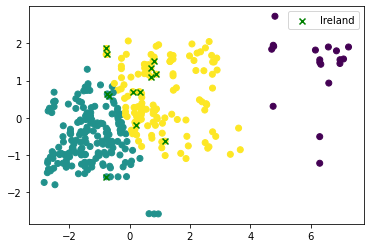

In [241]:
# Extract the columns we need from the DataFrame
yields = df_yields_x_pca['Yields']
x_pca = df_yields_x_pca['X_pca']
cluster = df_yields_x_pca['cluster']
geo = df_yields_x_pca['geo']

# Create a figure and axis
fig, ax = plt.subplots()

# Scatter plot the yield and X_pca values, coloring the points by cluster
ax.scatter(x_pca, yields, c=cluster)

# Highlight the points with geo == 'IE' by coloring the edges green
ie_mask = geo == 'IE'
ax.scatter(x_pca[ie_mask], yields[ie_mask], marker='x', c='g', label='Ireland')

# Add a legend
ax.legend()

# Show the plot
plt.show()